<H1> A Cut Above

The goal of this project is to construct a machine learning model to predict the relative skill of surgeons (the rate at which they have negative outcomes) using easy to obtain information. In general, it is very hard to find surgical outcome data. However, there is some available on checkbook.org that has already been adjusted for the relative risk of the undertaken procedures. For this project I will collect this outcome data and other information from checkbook and combine it with hospital quality scores from U.S. News and aggregated patient review data. After merging and cleaning these datasets, I will use them to build and validate a classification model that can be used to generate classifications for my accompanying web app.

In [2]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import sklearn
import seaborn as sns
import matplotlib as mp
import matplotlib.pyplot as plt
import time
import re
from statistics import mean

<H2> Data Collection

<H3>Surgeons: The ground truth data about the negative outcome rate of surgeons can be found on checkbook.org. To find the names of all relevant surgeons and the URL to a webpage with their individual information, I scraped the results page for each individual state.

In [1]:
#State ID codes stored to help loop through website
state_codes = ('AL','AK','AZ','AR','CA','CO','CT','DE','DC','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA',
              'ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA',
              'RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY')

In [4]:
#Information about the results of each surgeon is found on a unique webpage
#The URLs for these webpages are present in tables organized by state
#This code will iterate through the each state's results pages and extract surgeon name, URL, and surgeon's NPI number


#Construct a dataframe to store scraped information
Scrape = pd.DataFrame(columns = ['Surgeon', 'NPI', 'URL'])


#Loop will move through the results from each state and scrape information
for state in state_codes:

    #Variables for the while loop
    are_entries = True
    count = 1

    #While loop will iterate through each page of results for each state and stops when a page has no entries
    while are_entries == True:

        time.sleep(1)  #Institutes a short delay to not overwhelm website with requests

        #BeautifulSoup parses webpage HTML and isolates the table
        Sg = requests.get('https://www.checkbook.org/surgeonratings/Major-Bowel-Surgery/{}?Page={}'.format(state, str(count))).text
        Sg_soup = BeautifulSoup(Sg, 'lxml')
        Sg_table = Sg_soup.find('table')


        Doc = Sg_table.find_all('a')     #Gathers the entries in the webpage table

        count += 1     #Advances the count variable so next loop progresses to next page

        #Stop the while loop if the table in the webpage has no entries
        if len(Doc) == 0:

            are_entries = False
            pass

        #If the page has entries then enter for loop to extract info
        else:

            #loops through each entry from the website table
            for i in range(len(Doc)):

                #Regular expression searches to find locations of relevant info in each entry
                re1 = re.search('\">.*<', str(Doc[i]))
                re2 = re.search('/"', str(Doc[i]))
                re3 = re.search('(?<=\=)\S+\"', str(Doc[i]))


                #temporary dataframe to hold extracted info for each doctor
                df = pd.DataFrame([[str(Doc[i])[re1.span()[0]+2 : re1.span()[1]-2],
                                    str(Doc[i])[re2.span()[0]-10 : re2.span()[0]],
                                   'www.checkbook.org' + str(Doc[i])[re3.span()[0]+1 : re3.span()[1]-1]]],   #Domain portion of URL must be added
                                 columns = ['Surgeon', 'NPI', 'URL']) 

                #append each temporary dataframe to end of Scrape to build it row by row
                Scrape = Scrape.append(df, ignore_index = True)


In [915]:
#Code to scrape and extract surgeon name, URL, and surgeon's NPI number for Lung Surgeons

#Construct a dataframe to store scraped information
Scrape2 = pd.DataFrame(columns = ['Surgeon', 'NPI', 'URL'])


#Loop will move through the results from each state and scrape information
for state in state_codes:
    #Variables for the while loop
    are_entries = True
    count = 1

    #While loop will iterate through each page of results for each state and stops when a page has no entries
    while are_entries == True:

        time.sleep(0.4)  #Institutes a short delay to not overwhelm website with requests

        #BeautifulSoup parses webpage HTML and isolates the table
        Sg = requests.get('https://www.checkbook.org/surgeonratings/Lung-Surgery/{}?Page={}'.format(state, str(count))).text
        Sg_soup = BeautifulSoup(Sg, 'lxml')
        Sg_table = Sg_soup.find('table')


        Doc = Sg_table.find_all('a')     #Gathers the entries in the webpage table

        count += 1     #Advances the count variable so next loop progresses to next page

        #Stop the while loop if the table in the webpage has no entries
        if len(Doc) == 0:

            are_entries = False
            pass

        #If the page has entries then enter for loop to extract info
        else:

            #loops through each entry from the website table
            for i in range(len(Doc)):

                #Regular expression searches to find locations of relevant info in each entry
                re1 = re.search('\">.*<', str(Doc[i]))
                re2 = re.search('/"', str(Doc[i]))
                re3 = re.search('(?<=\=)\S+\"', str(Doc[i]))


                #temporary dataframe to hold extracted info for each doctor
                df = pd.DataFrame([[str(Doc[i])[re1.span()[0]+2 : re1.span()[1]-2],
                                    str(Doc[i])[re2.span()[0]-10 : re2.span()[0]],
                                   'www.checkbook.org' + str(Doc[i])[re3.span()[0]+1 : re3.span()[1]-1]]],   #Domain portion of URL must be added
                                 columns = ['Surgeon', 'NPI', 'URL']) 

                #append each temporary dataframe to end of Scrape to build it row by row
                Scrape2 = Scrape2.append(df, ignore_index = True)


In [919]:
Scrape2.to_csv('/Users/matthewowen/Desktop/Insight/Lung_Surgeon_URLs.csv')

<H3> Surgeon info: Using the collected URLS for individual surgeon pages, information was extracted including surgical outcomes, gender, certifications, med school and med school graduation year.

In [925]:
#Create dataframe to hold surgeon information
L_Surgeon_res = pd.DataFrame(columns = ['Surgeons', 'NPI', 'URL', 'Gender', 'Surgery Volume', 'Med School', 'Med Year',
                           'Residency', 'Certifications', 'Hospitals', '# Death Cases', 'Death Rate', 
                           '# Problem Cases', 'Problem Rate'])

#create list to store info about where there were issues retrieving info
L_problem_list = ['']

In [926]:
#Code for taking Surgeon URLs and scraping their individual information from checkbook.org

#Count variable allows for scraping in chunks and resuming where previously left off
count = 0

#Loops through previously scrpaed URLs for each individual surgeon's page
for URL in Scrape2['URL']:

    #block to prevent loop from stopping if there are any errors
    try:
        #Navigate to website and parse HTML
        rq = requests.get('http://' + URL).text
        time.sleep(0.25)
        rq_soup = BeautifulSoup(rq, 'lxml')
        rq_table = rq_soup.find('table')



        #isolates part of html with doctor names and number of cases
        title = list(rq_soup.findAll('div', {'class' : 'yTitle'}))

        #regular expression to find number of cases used in analysis
        d_cases = re.search('span>\((\w+)\W', str(title[0]))
        b_cases = re.search('span>\((\w+)\W', str(title[1]))

        #assigns case values to variables
        if 'cases' in str(title[0]):
            death_cases = int(d_cases[1])
        else:
            death_cases = -99    #if no value is indicated, -99 is inserted

        if 'cases' in str(title[1]):
            bad_cases = int(b_cases[1])
        else:
            bad_cases = -99     #if no value is indicated, -99 is inserted



        #isolates part of html with the percentages of deaths and bad outcomes
        pcts = list(rq_soup.findAll('div', {'class' : 'mediumVal'}))
        pctl = len(pcts)

        if pctl == 1:
            death_pct = -99    #if no value is indicated, -99 is inserted
        else:
            dpct_loc = re.search('">[0-9.]+%</div', str(pcts[0]))
            death_pct = float(str(pcts[0])[dpct_loc.span()[0]+2 : dpct_loc.span()[1]-6])

        #regular expression finds location of bad outcome rate
        bpct_loc = re.search('">[0-9.]+%</div', str(pcts[pctl-1]))
        bad_pct = float(str(pcts[pctl-1])[bpct_loc.span()[0]+2 : bpct_loc.span()[1]-6])

        
        #regular expression finds location of hospital names
        hosps= re.findall('</span>\w+(?:\W+[a-zA-Z0-9()]+){1,13}?</li>' , str(rq_table))
        hosp_list = ''
        
        #places hospitals in a semicolon separated list
        for i in range(len(hosps)):

            hosp_list = hosp_list + hosps[i][7:-5] + ';'


        #Parses html to find information stored in a table format and assigns entries to a list
        table_entries = list(rq_soup.findAll('td', {'class' : 'alignCenter'}))

        #identifies the gender of the physician
        if 'Male' in str(table_entries[1]):
            gender = 'Male'
        else:
            gender = 'Female'

        #isolates string for what relative volume of surgery they perform
        volume = str(table_entries[5])[25:-6]

        if len(volume) == 0:
            volume = 'N/A'      #empty entry gets recorded as N/A

        #isolates string for their medical school, if indicated
        med_school = str(table_entries[6])[25:-16]

        if len(str(table_entries[6])[25:-16]) == 0:
            med_school = 'N/A'      #empty entry gets recorded as N/A

        #isolates string for med school graduation year, if indicated
        med_year = str(table_entries[6])[-10:-6]

        if len(str(table_entries[6])[25:-16]) == 0:
            med_year = 'N/A'       #empty entry gets recorded as N/A

        #isolates string for internship and/or residency program
        res = str(table_entries[7])

        if len(res) < 35:
            residency = 'N/A'      #empty entry gets recorded as N/A

        else:
            resid = re.findall('px;">\w+(?:\W+[a-zA-Z]+){1,10}?</div>' , res)

            residency = resid[0][5:-6]


        #breaks table into a list of elements with the <ul> tag
        ul = rq_table.findAll('ul')

        #last element of above list contains board certifications
        #the string is split where </li> tags are to separate different certifications
        li_split = (str(ul[-1])).split('</li>')

        #if statement signifies if no certificate info is present
        if 'certificate' not in str(li_split):
            cert_list = 'None'

        else:

            #starts string with first certification
            cert_list = li_split[0][38:len(li_split[0])]

            #loop adds any other certifications separated by semicolons
            for i in range(len(li_split)-2):

                cert_list = cert_list + ';' + li_split[i+1][5:len(li_split[i+1])]

        #converts ampersands to 'and' thus getting rid of problematic semicolon
        cert_list = cert_list.replace('&amp;', 'and')
        residency = residency.replace('&amp;', 'and')
        hosp_list = hosp_list.replace('&amp;', 'and')
        med_school = med_school.replace('&amp;', 'and')


        #Collects the scraped info in a temporary dataframe that can be appended 
        #to the main one during each iteration of the loop
        df = pd.DataFrame([[Scrape2.iloc[count, 0], Scrape2.iloc[count, 1], Scrape2.iloc[count, 2],
                           gender, volume, med_school, med_year, residency, cert_list, hosp_list,
                           death_cases, death_pct, bad_cases, bad_pct]],
                          columns = ['Surgeons', 'NPI', 'URL', 'Gender', 'Surgery Volume', 'Med School', 'Med Year',
                               'Residency', 'Certifications', 'Hospitals', '# Death Cases', 'Death Rate', 
                               '# Problem Cases', 'Problem Rate'])

        L_Surgeon_res = L_Surgeon_res.append(df, ignore_index = True)

    #If there is an error retrieving info on a surgeon their name is printed and
    #added to a reference list
    except:
        print('Problem with ' + Scrape2['Surgeon'][count])
        L_problem_list.append(Scrape2['Surgeon'][count])
        
    count +=1

Problem with Dr. Peter N/a Pluscht
Problem with Dr. Robert Jay Standerfer
Problem with Dr. David J. Cziperle
Problem with Dr. Robert J. Robbins
Problem with Dr. Mahesh K. Ramchandani


In [38]:
L_Surgeon_res.head()

,Surgeons,NPI,URL,Gender,Surgery Volume,Med School,Med Year,Residency,Certifications,Hospitals,# Death Cases,Death Rate,# Problem Cases,Problem Rate
0,Dr. Paul Louis Cammack,1477637155,www.checkbook.org/surgeonratings/Lung-Surgery/...,Male,NaN,University of Alabama,1975,NaN,Thoracic and Cardiac Surgery,Baptist Medical Center South;,-99,-99.0,48,27.7
1,Dr. Robert Cerfolio,1245272483,www.checkbook.org/surgeonratings/Lung-Surgery/...,Male,NaN,University of Rochester,1988,Mayo Clinic-Rochester,Surgery;Thoracic and Cardiac Surgery,UAB Hospital;,426,6.6,408,26.8
2,Dr. Richard Lloyd Clay,1619960549,www.checkbook.org/surgeonratings/Lung-Surgery/...,Male,NaN,University of South Alabama,1981,Bridgeport Hosp,Thoracic and Cardiac Surgery,Huntsville Hospital;,-99,-99.0,45,36.1
3,Dr. Evan Scott Cohen,1235122177,www.checkbook.org/surgeonratings/Lung-Surgery/...,Male,NaN,Baylor University,1983,Baylor College of Medicine,Surgery;Thoracic and Cardiac Surgery,Huntsville Hospital;,127,3.1,122,17.9
4,Dr. Barry Glen Crowe,1710964739,www.checkbook.org/surgeonratings/Lung-Surgery/...,Male,NaN,University of Alabama,1996,NaN,Thoracic and Cardiac Surgery,East Alabama Medical Center;,-99,-99.0,18,26.8


<H3>Doctor reviews: Scrape and aggregate surgeon review scores off of google search pages which preview the average score and number of reviews.

In [1102]:
#create new lists to hold the review count and average score for each doctor
comp_review = []
rev_count = []

#loop through google searches for each surgeon to get review info
for name in L_Surgeon_res['Surgeons']:
    
    time.sleep(3)
    rep = name.replace(' ', '+')    #changes the name string to match google search URL format

    req = requests.get('https://www.google.com/search?safe=active&source=hp&q=MD+' + rep,
                      headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OSX 12.6; rv:76.0.1) Gecko/20100101 Firefox/76.0.1'}).text
    req_soup = BeautifulSoup(req, 'lxml')

    #creates list of all html strings of class that denote information on reviews
    d_list = list(req_soup.findAll('div',{'class': 'dhIWPd f'}))
    
    #creates lists to store info from each review site
    rev = []
    rnum = []

    
    #if no review info is found, NaN is added for that surgeon
    if len(d_list) == 0:

        comp_review.append(np.nan)
        rev_count.append(np.nan)

    else:

        try:
        
            #loops through html strings to extract numbers
            for i in range(len(d_list)):

                
                #regular expressions to find locations of relevant info in string
                p1 = re.search('Rating: ', str(d_list[i]))
                p2 = re.search('[0-9] - ', str(d_list[i]))
                p3 = re.search(' vote', str(d_list[i]))
                p4 = re.search(' review', str(d_list[i]))


                #distinguish between entries that use the word 'vote' vs. 'review'
                if 'vote' in str(d_list[i]):

                    rev.append(float(str(d_list[i])[p1.span()[1]:p2.span()[0]+1]))
                    rnum.append(int(str(d_list[i])[p2.span()[1]+1:p3.span()[0]]))

                elif ' review' in str(d_list[i]):

                    rev.append(float(str(d_list[i])[p1.span()[1]:p2.span()[0]+1]))
                    rnum.append(int(str(d_list[i])[p2.span()[1]+1:p4.span()[0]]))

                else:
                    pass

            #use the assembled lists to find the total number of reviews and avg
            #scores for each surgeon and append them to lists
            rtot = sum([rev[j] * rnum[j] for j in range(len(rev))])
            rcount = sum(rnum)

            comp_review.append((rtot/rcount))
            rev_count.append(rcount)
            
        #if any issues with extracting info, then add NaN for surgeon    
        except:
            
            comp_review.append(np.nan)
            rev_count.append(np.nan)


Dr. Mark Hayden Cooper
Dr. Geoffrey R. Cousins
Dr. John T. Deel
Dr. Edmundo E. Figueroa
Dr. Adam J. Hansen
Dr. Jonathan Kiev
Dr. Alexander Arpad Nagy
Dr. Olusola Oduntan
Dr. Albert Francois Olivier
Dr. Ramanathan Sampath
Dr. Kevin Tveter
Dr. Nicholas Vito Augelli
Dr. Thomas T. Carmody
Dr. Lale Douglas Cowgill
Dr. John We Douglas Jones
Dr. Francis Xavier Downey
Dr. Mario Giacomo Gasparri
Dr. Steven J. Gerndt
Dr. George Bruce Haasler
Dr. James David Hall
Dr. John A. Johnkoski
Dr. David W. Johnstone
Dr. Santosh N. Krishnan
Dr. Chong Chin Lee
Dr. Vincent Gregory Lee
Dr. Hope S. Maki
Dr. James D. Maloney
Dr. Peter H. Marks
Dr. Daniel P. O'Hair
Dr. Daryl P. Pearlstein
Dr. Charles F. Reuben
Dr. Fernando A. Riveron
Dr. Alexander Roitstein
Dr. John Forrest Seccombe
Dr. Paul E. Seifert
Dr. John M. Snider
Dr. William B. Tisol
Dr. John L. Waciuma
Dr. Robert J. Wiechmann
Dr. Kenneth M. Wolnak


In [1110]:
#Add average review and review counts to lung surgeon dataframe
L_Surgeon_res['Avg Review'] = comp_review
L_Surgeon_res['# of Reviews'] = rev_count

<H4> About 10% of surgeons have no review information. In order to preserve them in the analysis, I regressed the average review score for each surgeon against their problem rate and then use the regression fit to impute what the review score would be for a surgeon with an average problem rate. I then assign this value to all the surgeons with NaN review values.

In [1128]:
#Check what avg problem rate is for surgeons with NaN reviews
print(L_Surgeon_res[L_Surgeon_res['Avg Review'].isna()]['Problem Rate'].mean())
print(L_Surgeon_res['Problem Rate'].mean())

25.55242718446602
26.531417910447754


In [1141]:
L_Surg_Reg = L_Surgeon_res[['Avg Review', 'Problem Rate']]

L_Surg_Reg.dropna(axis = 0, inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [1143]:
from sklearn.linear_model import LinearRegression

#Use linear regression to find the best fit line relating reviews and outcomes
LR_X = L_Surg_Reg[['Avg Review']]
LR_Y = L_Surg_Reg['Problem Rate']

Linreg = LinearRegression().fit(LR_X, LR_Y)

print(Linreg.intercept_)
print(Linreg.coef_[0])

32.15139493133799
-1.2702682795358613


In [1144]:
#Use regression fit to find the review score that returns average problem rate
NA_value = ((L_Surgeon_res['Problem Rate'].mean() - Linreg.intercept_) / Linreg.coef_[0])

print(NA_value)

4.4242441627714255


In [1145]:
#Replace NaN review values with imputed average value
L_Surgeon_res['Avg Review'].fillna(NA_value, inplace=True)

In [1111]:
L_Surgeon_res.to_csv('/Users/matthewowen/Insight-A_Cut_Above/L_Surgeon_Training_Set.csv')

<H3> Hospital scores: U.S. News and World Reports assigns score to hospitals for the specialization of pulmonology and lung surgery. I scraped the scores and location information for all rated US hospitals.

In [948]:
#tuple of state designations needed to systematically find national U.S. News hospital information
states = ('alabama', 'alaska', 'arizona', 'arkansas', 'california', 'colorado', 'connecticut', 'delaware',
              'dc', 'florida', 'georgia', 'hawaii', 'idaho', 'illinois', 'indiana', 'iowa', 'kansas', 'kentucky',
              'louisiana', 'maine', 'maryland', 'massachusetts', 'michigan', 'minnesota', 'mississippi', 'missouri',
              'montana', 'nebraska', 'nevada', 'new-hampshire', 'new-jersey', 'new-mexico', 'new-york',
              'north-carolina', 'north-dakota', 'ohio', 'oklahoma', 'oregon', 'pennsylvania', 'rhode-island',
              'south-carolina', 'south-dakota', 'tennessee', 'texas', 'utah', 'vermont', 'virginia', 'washington',
              'west-virginia', 'wisconsin', 'wyoming')

In [974]:
#This block scrapes information from the US News hospital rankings for gastroenterology and GI surgery
#Specifically the code will extract the name of each hospital, its score and location information

#create lists to store the information that will be scraped
h_names = []
h_scores = []
city_names = []
state_names = []
ZIP_codes = []
h_links = []

#dictionary that matches name of hospital with its score
hosp_dict2 = {}

#cycles through results pages for each state by inserting specific state name in URL
for state in states:

    
    are_entries = True
    
    #count variable and while loop allow cycling through multiple results pages for certain states
    count = 1
    while are_entries == True:
        
        time.sleep(0.3) #short delay between requests to prevent IP blocking
        URL='https://health.usnews.com/best-hospitals/rankings/pulmonology/{}?page={}'.format(state, count)
        header = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OSX 12.6; rv:76.0.1) Gecko/20100101 Firefox/76.0.1'}
        
        rq = requests.get(URL, headers = header).text
        rq_soup = BeautifulSoup(rq, 'lxml')


        if 'Page Not Found!' in str(rq_soup):  #detects when results pages have run out and ends loop

            are_entries = False
            pass


        else:

            
            count += 1
            
            #isolates html elements that contain the hospital data
            h_list = list(rq_soup.findAll('li', {'class' : 'item-list__ListItemStyled-sc-2qxw3-1 dLnQUJ'}))

            #loops through and extracts info for each hospital on each page
            for i in range(len(h_list)):

                if 'Ad__Container' in str(h_list[i]):   #skips past ads picked up in the list
                    pass

                else:   
                    
                    #finds hospital name
                    hosp = h_list[i].findAll('a')[1]
                    h_start = re.search('">', str(hosp))
                    hosp_name = str(hosp)[h_start.span()[1]:-4]

                    
                    #finds hospital score
                    sco = h_list[i].findAll('dd')
                    sco_start = re.search('">', str(sco))
                    score = str(sco)[sco_start.span()[1]:-10]
                    
                    #finds link to hospital scorecard
                    link = h_list[i].findAll('a')[3]
                    link_start = re.search('href="', str(link))
                    link_stop = re.search('" letter', str(link))
                    hosp_link = str(testy)[link_start.span()[1]:link_stop.span()[0]]
                    

                    #scrapes out the location information for each hospital
                    if 'PhoneIconStyled' in str(h_list[i].findAll('p')[0]):   #if statement makes it work with
                                                                              #or without phone number in the info box
                        loc = h_list[i].findAll('p')[1]
                    else:

                        loc = h_list[i].findAll('p')[0]

                    #regular expressions locate string positions with 'city, state ZIP' format
                    loc_start = re.search('">', str(loc))
                    loc_state = re.search(',\W[A-Z]{2}\W[0-9]', str(loc))

                    city = str(loc)[loc_start.span()[1] : loc_state.span()[0]]
                    sta = str(loc)[loc_state.span()[0]+2 : loc_state.span()[0]+4]
                    ZIP = str(loc)[loc_state.span()[1]-1 : -4]


                    #extend the lists and dictionary entry by entry
                    h_names.append(hosp_name)
                    h_scores.append(score)
                    city_names.append(city)
                    state_names.append(sta)
                    ZIP_codes.append(ZIP)
                    h_links.append(hosp_link)
                    
                    hosp_dict2.update({hosp_name : float(score)})

In [985]:
#Dataframe constructed to store the scraped hospital information
L_Hosp_data = pd.DataFrame({'Hospital': h_names, 'City': city_names, 'State': state_names, 'ZIP Code': ZIP_codes,
                         'Score': h_scores, 'Score URL': h_links})

<H3> Hospital names in the hospital dataframe are replaced with designations that are used in the surgeon dataframe so that surgeons can be matched to their hospital(s). Dictionary used can be found at the bottom of the notebook.

In [42]:
#Use dictionary to replace names in the hospital dataframe
L_Hosp_data2 = L_Hosp_data.replace(to_replace = hosp_replace)

In [43]:
#drop hospitals where names are exact duplicates
L_Hosp_data2.drop([815, 1510, 20, 1405, 885, 662, 433, 293, 1376, 1199, 302, 947, 189, 1258], axis=0, inplace=True)

In [681]:
L_Hosp_data2[['Hospital', 'City', 'State', 'ZIP Code', 'Score']].to_csv('/Users/matthewowen/A_Cut_Above_App/L_hosps.csv')


<H3>Assign each surgeon the average of the hospital scores of each hospital they are associated with.

In [44]:
#Use hospital dataframe to make a dictionary of hospitals and their scores
hosp_dict = {}

for hos in L_Hosp_data2['Hospital']:

    hosp_dict.update({hos : float(L_Hosp_data2[L_Hosp_data2['Hospital']==hos]['Score'])})

In [1154]:
#Create list of scores to add as column of surgeon dataframe
hospscores = []

#loop through surgeons, make a list of their hospitals, then use dictionary
#to make a list of associated scores
for i in range(len(L_Surgeon_res2['Surgeons'])):
    
    #get hospital string
    h = L_Surgeon_res2.iloc[i, 7]
    
    #split strings at semicolon to generate list of hospitals
    h2 = h.split(';')
    
    #create list to hold scores
    hsc = []

    for x in h2:

        if x in hosp_dict:

            hsc.append(hosp_dict[x])

        else:

            pass
    
    #if no hospitals matched ones with scores, assign NaN
    if len(hsc) ==0:
        
        hospscores.append(np.nan)
        
    else:
        
        #either mean of hospital scores or score of best hospital can be output
        hsc.sort(reverse = False)
        #hospscores.append(hsc[0])
        hospscores.append(mean(hsc))


In [1156]:
L_Surgeon_res2['Hospital Score'] = hospscores

In [62]:
L_Surgeon_res = pd.read_csv('L_Surgeon_Training_Set.csv', index_col=0)

In [393]:
print(L_Surgeon_res['Problem Rate'].mean())
print(L_Surgeon_res['Problem Rate'].std())

26.531417910447754
8.886856953770623


<H3>Alternative quality score that takes into account death rate for surgeons where that information is available.

In [400]:
#Code for generating a combined surgeon quality rating for those who have values for death rate
comb_score = []

avgD = L_Surgeon_res[L_Surgeon_res['Death Rate'] != -99]['Death Rate'].mean()
stdD = L_Surgeon_res[L_Surgeon_res['Death Rate'] != -99]['Death Rate'].std()
avgP = L_Surgeon_res['Problem Rate'].mean()
stdP = L_Surgeon_res['Problem Rate'].std()

for i in range(L_Surgeon_res.shape[0]):
    
    PR = (L_Surgeon_res.iloc[i, 13] - avgP) / stdP
    
    if L_Surgeon_res.iloc[i, 10] == -99:
        
        comb_score.append(PR)
    
    else:
        
        DR = (L_Surgeon_res.iloc[i, 11] - avgD) / stdD
        
        comb_score.append((PR + DR)/2)



In [407]:
L_Surgeon_res['Combined Score'] = comb_score

<H3>Clean the data and prepare it for EDA and modeling

In [1148]:
#Remove columns with too many NaN values and drop any remaining rows that are NaN
L_Surgeon_res2 = L_Surgeon_res.drop(columns = ['Surgery Volume', 'Residency'])
L_Surgeon_res2.dropna(axis=0, inplace=True)

In [1158]:
#create new dataframe that only includes surgeons with a medical school graduation year
L_Surg_Data = L_Surgeon_res2[(L_Surgeon_res2['Med Year'] != 'N/A') & (L_Surgeon_res2['Med Year'] != 'br/>')]

In [1159]:
#change med year to integer type
L_Surg_Data = L_Surg_Data.astype({'Med Year':'int32'})

In [1160]:
#encode gender with dummy variables
L_Surg_Data.replace(to_replace = {'Male': 1, 'Female': 0}, inplace=True)

In [2096]:
#rename the Problem Rate column
L_Surg_Data.rename(columns = {'Problem Rate' : '% Negative Outcome'}, inplace = True)

In [1759]:
#drop surgeons with outlier review scores
L_Surg_Data.drop(L_Surg_Data[L_Surg_Data['Avg Review']<2].index, axis = 0, inplace = True)

In [2518]:
#Create dummie variables for foreign vs. domestic medical school

med_status = []

for med in L_Surg_Data['Med School']:
    
    if 'Foreign' in med:
        
        med_status.append(1)
        
    else:
        
        med_status.append(0)
        
L_Surg_Data['Foreign Med'] = med_status

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [1657]:
#Create dummie variables for thoracic surgery board certification or not

cert_status = []

for cert in L_Surg_Data['Certifications']:
    
    if 'Thoracic' in cert:
        
        cert_status.append(1)
        
    else:
        
        cert_status.append(0)
        
L_Surg_Data['Thoracic Cert'] = cert_status

<H3>Exploratory Data Analysis: Model features correlate poorly with surgical outcomes.

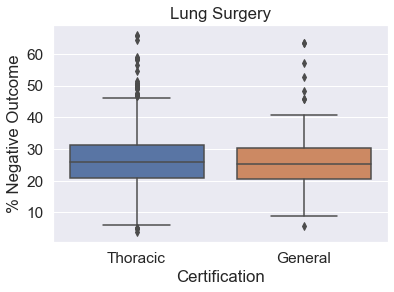

In [2098]:
#Plots outcome distributions for doctors with thoracic surgery certification vs those without
sns.boxplot(data = (L_Surg_Data[L_Surg_Data['Certifications'].str.contains('Thoracic and Cardiac Surgery')]['% Negative Outcome'],
                    L_Surg_Data[L_Surg_Data['Certifications'].str.contains('Thoracic and Cardiac Surgery')==False]['% Negative Outcome']),
            orient = 'v')
plt.xlabel('Certification')
plt.ylabel('% Negative Outcome')
plt.xticks(ticks  = [0,1], labels = ['Thoracic', 'General'])
plt.title('Lung Surgery')

plt.savefig('/Users/matthewowen/Desktop/Insight/Thoracic_Cert.png')
plt.show()

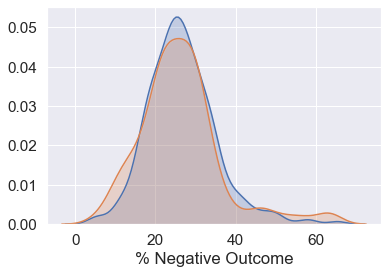

In [2104]:
#Density plot of the same data as above
sns.distplot(L_Surg_Data[L_Surg_Data['Certifications'].str.contains('Thoracic and Cardiac Surgery')]['% Negative Outcome'],
             hist = False, kde = True,kde_kws = {'shade': True, 'linewidth': 1.5})
sns.distplot(L_Surg_Data[L_Surg_Data['Certifications'].str.contains('Thoracic and Cardiac Surgery') == False]['% Negative Outcome'],
             hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1.5})


plt.show()

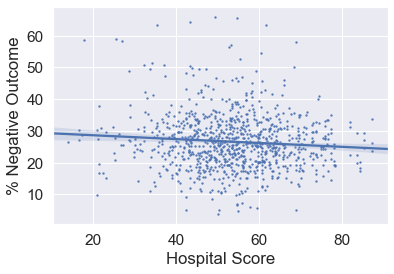

In [2099]:
sns.regplot(L_Surg_Data['Hospital Score'], L_Surg_Data['% Negative Outcome'], scatter_kws={'s':2})
plt.show()

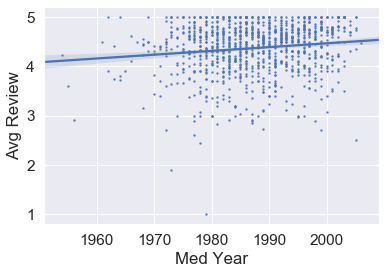

In [1163]:
sns.regplot(L_Surg_Data['Med Year'], L_Surg_Data['Avg Review'], scatter_kws={'s':2})
plt.show()

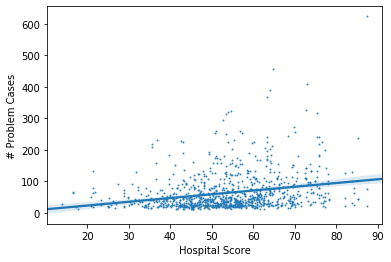

In [130]:
sns.regplot(L_Surg_Data['Hospital Score'], L_Surg_Data['# Problem Cases'], scatter_kws={'s':1})

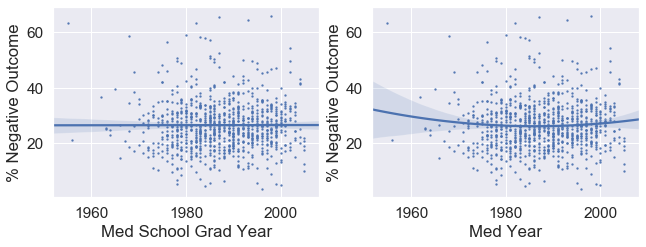

In [2124]:
plt.figure(figsize = [10.5, 3.5])

#fitting a line to the distribution
plt.subplot(1,2,1)
sns.regplot(L_Surg_Data['Med Year'], L_Surg_Data['% Negative Outcome'], scatter_kws={'s':2})

plt.xlabel('Med School Grad Year')

#Try fitting a quadratic to the distribution
plt.subplot(1,2,2)
sns.regplot(L_Surg_Data['Med Year'], L_Surg_Data['% Negative Outcome'], order = 2, scatter_kws={'s':2})

plt.show()

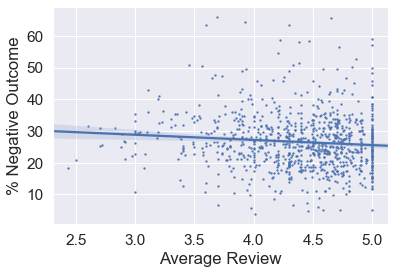

In [2123]:
sns.regplot(L_Surg_Data['Avg Review'], L_Surg_Data['% Negative Outcome'], scatter_kws={'s':2})

plt.xlabel('Average Review')

plt.show()

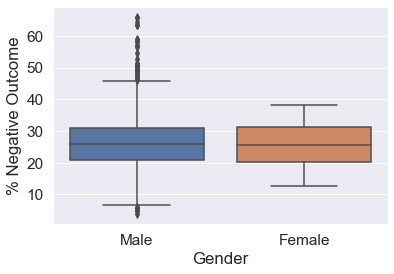

In [2102]:
#Outcome distribution for males and females
sns.boxplot(data = (L_Surg_Data[L_Surg_Data['Gender'] == 1]['% Negative Outcome'],
                    L_Surg_Data[L_Surg_Data['Gender'] == 0]['% Negative Outcome']), orient = 'v')
plt.xlabel('Gender')
plt.ylabel('% Negative Outcome')
plt.xticks(ticks  = [0,1], labels = ['Male', 'Female'])

plt.show()

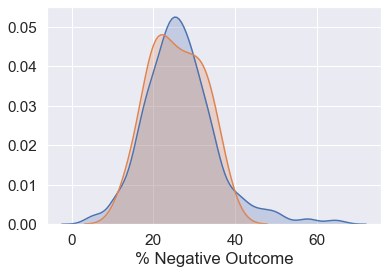

In [2103]:
#Density plot for above data
sns.distplot(L_Surg_Data[L_Surg_Data['Gender'] == 1]['% Negative Outcome'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1.5})
sns.distplot(L_Surg_Data[L_Surg_Data['Gender'] == 0]['% Negative Outcome'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1.5})


plt.show()

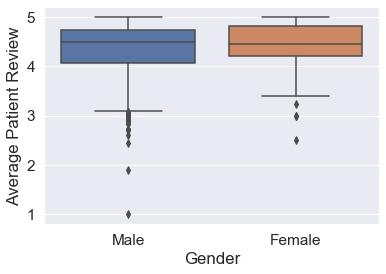

In [1165]:
#Review score distribution for males and females
sns.boxplot(data = (L_Surg_Data[L_Surg_Data['Gender'] == 1]['Avg Review'],
                    L_Surg_Data[L_Surg_Data['Gender'] == 0]['Avg Review']), orient = 'v')
plt.xlabel('Gender')
plt.ylabel('Average Patient Review')
plt.xticks(ticks  = [0,1], labels = ['Male', 'Female'])

plt.show()

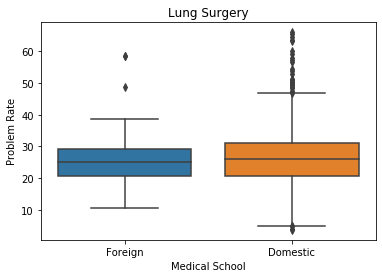

In [2460]:
sns.boxplot(data = (L_Surg_Data[L_Surg_Data['Med School'].str.contains('Foreign')]['% Negative Outcome'],
                    L_Surg_Data[L_Surg_Data['Med School'].str.contains('Foreign')==False]['% Negative Outcome']),
            orient = 'v')
plt.xlabel('Medical School')
plt.ylabel('% Negative Outcome')
plt.xticks(ticks  = [0,1], labels = ['Foreign', 'Domestic'])
plt.title('Lung Surgery')

plt.show()

<H3>Classification: Due to the low amount of signal in the data I will subdivide the outcomes into 3 classes defined by the mean and standard deviation of the data. A predictive model will then be built using these classes.

In [529]:
#Sort the surgeons by surgical outcome rate
L_Surg_Data.sort_values(by = '% Negative Outcome', inplace = True)

In [134]:
#calculate mean and standard deviation to see where class cutoffs will be (+/- 1 stdev from mean)
print(L_Surg_Data['% Negative Outcome'].mean())
print(L_Surg_Data['% Negative Outcome'].std())

26.439596136962226
8.955044145841741


In [1173]:
#Designates one of 3 class labels to each physician according to their problem rate

classes = []

#define avg and stdev of outcome distribution
avg = L_Surg_Data['% Negative Outcome'].mean()
stdev = L_Surg_Data['% Negative Outcome'].std()


for rate in L_Surg_Data['% Negative Outcome']:
    
    if rate < (avg-stdev):
        
        classes.append(1)
    
    elif rate > (avg+stdev):
        
        classes.append(3)
        
    else:
        
        classes.append(2)

#add class designations to surgeon dataframe
L_Surg_Data['Class'] = classes

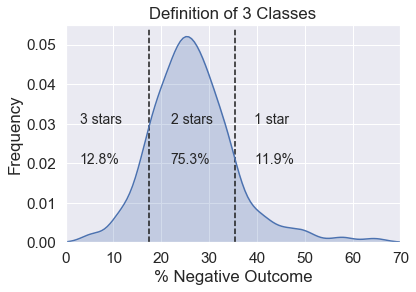

In [2122]:
#chart showing how classes are defined
sns.distplot(L_Surg_Data['% Negative Outcome'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1.5})
plt.xlim(0,70)
plt.ylim(0, 0.055)
plt.title('Definition of 3 Classes')
plt.ylabel('Frequency')

#plot class designations
plt.text(x = 3, y = 0.03, s = '3 stars', fontsize = 14)
plt.text(x = 22, y = 0.03, s = '2 stars', fontsize = 14)
plt.text(x = 39.5, y = 0.03, s = '1 star', fontsize = 14)

#plot class frequencies
plt.text(x = 3, y = 0.02, s = '12.8%', fontsize = 14)
plt.text(x = 22, y = 0.02, s = '75.3%', fontsize = 14)
plt.text(x = 39.5, y = 0.02, s = '11.9%', fontsize = 14)

#plot lines that divide classes
plt.vlines(x = [17.4, 35.4], ymin = 0, ymax = 0.054, linestyles = 'dashed')

#export chart
plt.savefig('/Users/matthewowen/Desktop/Insight/class_definition.png')

plt.show()

<H3> I will test a variety of classification models to find the one that maximizes the weighted precision of class assignments, with a priority on correct assignment of class 1.

In [2093]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X = L_Surg_Data[['Gender', 'Med Year', 'Avg Review', 'Hospital Score']]
y = L_Surg_Data['Class']

#X = StandardScaler().fit_transform(X)
X = MinMaxScaler().fit_transform(X)

#Set aside 30% of the data for model testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)


In [ ]:
#tune logistic regression model
Logreg = LogisticRegression(random_state=18, class_weight= {1:140, 2:7, 3:100})

#train model
Logreg.fit(X_train, y_train)

Y_pred = Logreg.predict(X_test)

In [1341]:
print(f'Accuracy Score: {accuracy_score(y_test, Y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, Y_pred)}')

Accuracy Score: 0.5179856115107914
Confusion Matrix: 
[[ 10  25   1]
 [ 65 132   7]
 [ 15  21   2]]


<H3> SVM classifiers were the best performing models in terms of the chosen metric of weighted precision.

In [2107]:
from sklearn.svm import SVC

#initiate SVM model with linear kernel
svmL = SVC(kernel = 'linear', C=550, gamma = 0.1, class_weight = {1:124.5, 2:25.5, 3:140}, random_state=8)

#perform 3-fold cross validation
cv_scores = cross_val_score(svmL, X_train, y_train, cv=3, scoring = 'precision_weighted')

#display weighted precision score and error
print("Precision: %0.3f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

Precision: 0.602 (+/- 0.01)


In [2109]:
#Evaluate same classification model using the test set
svmL = SVC(kernel = 'linear', C=550, gamma = 0.1, class_weight = {1:124.5, 2:25.5, 3:140}, random_state=8)

#fit model
svmL.fit(X_train, y_train)

#predict classes of test data
svmL_pred = svmL.predict(X_test)

#Display results
print(f'Precision Score: ' + str(precision_score(y_test, svmL_pred, average='weighted')))
print(f'Confusion Matrix: \n{confusion_matrix(y_test, svmL_pred)}')

Precision Score: 0.667691536127496
Confusion Matrix: 
[[ 13  14   5]
 [ 50 104  59]
 [ 11   9  13]]


In [1946]:
#SVM classifier using default rbf kernel
svm = SVC(C=85, gamma = 0.56, class_weight = {1:258, 2:53.9, 3:256}, random_state=8)

#3-fold cross validation
cv_scores = cross_val_score(svm, X_train, y_train, cv=3, scoring = 'precision_weighted')

print("Precision: %0.3f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

Precision: 0.609 (+/- 0.04)


In [1939]:

svm = SVC(C=85, gamma = 0.56, class_weight = {1:258, 2:53.9, 3:256}, random_state=8)

svm.fit(X_train, y_train)


svm_pred = svm.predict(X_test)

#display results
print(f'Precision Scores: ' + str(precision_score(y_test, svm_pred, average='weighted')))
print(f'Confusion Matrix: \n{confusion_matrix(y_test, svm_pred)}')

Precision Scores: 0.6189577451962479
Confusion Matrix: 
[[ 10  19   3]
 [ 61 121  31]
 [  9  18   6]]


In [2006]:
recall_score(y_test, svmL_pred, average='weighted')

0.4676258992805755

<H3> To validate how well the model performed versus random the predicted class list was shuffled 50 times and the precision score was calculated for each ordering and the mean value of these was calculated

In [2079]:
import random

r_list = []

count = 1

while count < 50:
    
    
    rand_pred = random.sample(list(svmL_pred), len(svmL_pred))
    r = precision_score(y_test, rand_pred, average='weighted')
    
    r_list.append(r)
    
    count += 1

In [2080]:
mean(r_list)

0.6123350940003484

<H3> Converting predicted classes into easy to understand star ratings.

In [2113]:
stars = []

for i in range(L_Surg_SVM.shape[0]):
    
    if L_Surg_SVM.iloc[i,5] == 1:
        
        stars.append('3 stars')
        
    elif L_Surg_SVM.iloc[i,5] == 2:
        
        stars.append('2 stars')
        
    else:
        
        stars.append('1 star')

In [2114]:
L_Surg_SVM['Rating'] = stars

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [2126]:
round(L_Surg_SVM['Avg Review'],2)

0       3.94
1       4.67
2       4.14
3       4.86
4       4.00
        ... 
1332    4.79
1333    4.50
1334    4.35
1337    4.80
1338    5.00
Name: Avg Review, Length: 924, dtype: float64

In [2128]:
L_Surg_SVM.head()

,Surgeons,Hospitals,Avg Review,% Negative Outcome,Class,Predicted Class,Rating
0,Dr. Paul Louis Cammack,Baptist Medical Center South;,3.937931,27.7,2,3,1 star
1,Dr. Robert Cerfolio,UAB Hospital;,4.666087,26.8,2,2,2 stars
2,Dr. Richard Lloyd Clay,Huntsville Hospital;,4.142857,36.1,3,3,1 star
3,Dr. Evan Scott Cohen,Huntsville Hospital;,4.859036,17.9,2,1,3 stars
4,Dr. Barry Glen Crowe,East Alabama Medical Center;,4.000000,26.8,2,3,1 star


In [2127]:
L_Surg_SVM.to_csv('/Users/matthewowen/A_Cut_Above_App/Lung_Surgeons.csv')

<H3> A learning curve shows that the precision score of the SVM model calculated on the test set does not increase with an increasing number of samples, implying that the model is underfit.

In [1746]:
from sklearn.model_selection import learning_curve

learning_curve(svmL, X_train, y_train, train_sizes = np.array([100, 150, 200, 250, 300, 350, 400]), scoring = 'precision_weighted')


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-pa

(array([100, 150, 200, 250, 300, 350, 400]),
 array([[0.71685606, 0.75264513, 0.75264513],
        [0.68795178, 0.679599  , 0.679599  ],
        [0.6727319 , 0.69248355, 0.69248355],
        [0.68595009, 0.67201718, 0.68629627],
        [0.66943382, 0.64911194, 0.65726563],
        [0.65297848, 0.63857421, 0.64926496],
        [0.75119888, 0.65420715, 0.66191206]]),
 array([[0.60595805, 0.58637086, 0.65976864],
        [0.64164811, 0.62644459, 0.62593828],
        [0.58835749, 0.61680481, 0.62484461],
        [0.59908231, 0.63468598, 0.65919626],
        [0.58564673, 0.59948167, 0.65397021],
        [0.57864597, 0.57606005, 0.62054778],
        [0.57562594, 0.61029072, 0.61954857]]))

<H3> Other classification models were tried but were less successful at classifying surgeons.

In [2047]:
from sklearn.ensemble import RandomForestClassifier

#tune random forest parameters
rfc = RandomForestClassifier(n_estimators=30, random_state=24, class_weight = {1:148000, 2:0.0033, 3:100000})

#fit RF classifier
rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)

#show results
print(f'Accuracy Score: {accuracy_score(y_test, rfc_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, rfc_pred)}')

Accuracy Score: 0.5143884892086331
Confusion Matrix: 
[[  6  25   1]
 [ 50 133  30]
 [  6  23   4]]


In [2073]:
from imblearn.over_sampling import SMOTE

#use SMOTE to upsample the minority classes
sm = SMOTE(sampling_strategy = 'not majority', random_state=20)
X_train, y_train = sm.fit_sample(X_train, y_train)

#git a random forest classifier
smote = RandomForestClassifier(n_estimators=90, random_state=24, class_weight = {1:18000, 2:0.0032, 3:140}).fit(X_train, y_train)

smote_pred = smote.predict(X_test)

#show results
print(f'Accuracy Score: ' + str(precision_score(y_test, smote_pred, average = 'weighted')))
print(f'Confusion Matrix: \n{confusion_matrix(y_test, smote_pred)}')

Accuracy Score: 0.5814023067260476
Confusion Matrix: 
[[  8  19   5]
 [ 62 108  43]
 [  2  23   8]]


In [2018]:
from sklearn.naive_bayes import GaussianNB

#try implementing model with gaussian naive bayes algorithm
gnb = GaussianNB()

gnb.fit(X_train, y_train)

Y_pred_GNB = gnb.predict(X_test)

In [2019]:
print(f'Accuracy Score: {accuracy_score(y_test, Y_pred_GNB)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, Y_pred_GNB)}')

Accuracy Score: 0.7661870503597122
Confusion Matrix: 
[[  0  32   0]
 [  0 213   0]
 [  0  33   0]]


In [2074]:
from sklearn.naive_bayes import ComplementNB

#try implementing model with complement naive bayes algorithm
cnb = ComplementNB()

cnb.fit(X_train, y_train)

Y_pred_CNB = cnb.predict(X_test)

In [2075]:
print(f'Accuracy Score: {accuracy_score(y_test, Y_pred_CNB)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, Y_pred_CNB)}')

Accuracy Score: 0.3489208633093525
Confusion Matrix: 
[[18  7  7]
 [63 64 86]
 [14  4 15]]


<H3>Linear regression shows a very low value of R^2, bolstering the decision to use a classification scheme.

In [2520]:
from sklearn import linear_model
from sklearn import preprocessing

#assign independent and dependent variables
X = L_Surg_Data[['Gender', 'Med Year', '# Problem Cases', 'Hospital Score', 'Foreign Med', 'Thoracic Cert']]
Y = L_Surg_Data['% Negative Outcome']

#rescale model inputs
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

regr = linear_model.LinearRegression()

regr.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [2521]:
#prints the regression coefficients and R^2 score
print('Coefficients:')
print('Gender: ' + str(round(regr.coef_[0], 2)))
print('Med Year: ' + str(round(regr.coef_[1], 2)))
print('# Problem Cases: ' + str(round(regr.coef_[2], 2)))
print('Hospital Score: ' + str(round(regr.coef_[3], 2)))
print('Foreign Med: ' + str(round(regr.coef_[4], 2)))
print('Thoracic Cert: ' + str(round(regr.coef_[5], 2)))
print('R^2: ', round(regr.score(X, Y), 4))

Coefficients:
Gender: 0.19
Med Year: 0.42
# Problem Cases: -0.13
Hospital Score: -0.73
Foreign Med: -0.03
Thoracic Cert: 0.17
R^2:  0.0096


<H3>Exploratory analysis using only surgeons with a more certain negative outcome rate (more cases used to calculate it) shows a worse outcome for linear regression.

In [2526]:
L_Surg_Data2 = L_Surg_Data[L_Surg_Data['# Problem Cases'] > 35]

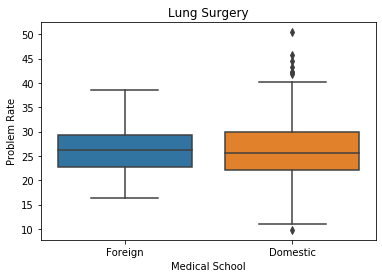

In [2464]:
sns.boxplot(data = (L_Surg_Data2[L_Surg_Data2['Med School'].str.contains('Foreign')]['% Negative Outcome'],
                    L_Surg_Data2[L_Surg_Data2['Med School'].str.contains('Foreign')==False]['% Negative Outcome']),
            orient = 'v')
plt.xlabel('Medical School')
plt.ylabel('% Negative Outcome')
plt.xticks(ticks  = [0,1], labels = ['Foreign', 'Domestic'])
plt.title('Lung Surgery')

plt.figure(figsize = [10.5, 3.5])

plt.subplot(1,2,1)plt.show()

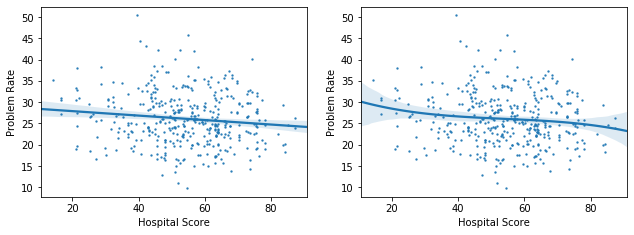

In [2493]:
plt.figure(figsize = [10.5, 3.5])

plt.subplot(1,2,1)
sns.regplot(L_Surg_Data2['Hospital Score'], L_Surg_Data2['% Negative Outcome'], scatter_kws={'s':2})

plt.subplot(1,2,2)
sns.regplot(L_Surg_Data2['Hospital Score'], L_Surg_Data2['% Negative Outcome'], order = 3, scatter_kws={'s':2})

plt.show()

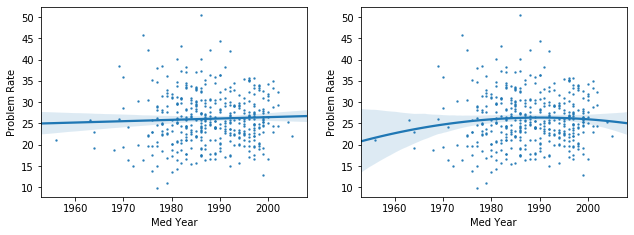

In [2491]:
plt.figure(figsize = [10.5, 3.5])

plt.subplot(1,2,1)
sns.regplot(L_Surg_Data2['Med Year'], L_Surg_Data2['% Negative Outcome'], scatter_kws={'s':2})

plt.subplot(1,2,2)
sns.regplot(L_Surg_Data2['Med Year'], L_Surg_Data2['% Negative Outcome'], order = 2, scatter_kws={'s':2})

plt.show()

In [2527]:
X2 = L_Surg_Data2[['Gender', 'Med Year', '# Problem Cases', 'Hospital Score', 'Foreign Med', 'Thoracic Cert']]
Y2 = L_Surg_Data2['% Negative Outcome']

X2 = preprocessing.StandardScaler().fit(X2).transform(X2.astype(float))

regr2 = linear_model.LinearRegression()

regr2.fit(X2, Y2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [2528]:
#prints the regression coefficients and R^2 score
print('Coefficients:')
print('Gender: ' + str(round(regr2.coef_[0], 2)))
print('Med Year: ' + str(round(regr2.coef_[1], 2)))
print('# Problem Cases: ' + str(round(regr2.coef_[2], 2)))
print('Hospital Score: ' + str(round(regr2.coef_[3], 2)))
print('Foreign Med: ' + str(round(regr2.coef_[4], 2)))
print('Thoracic Cert: ' + str(round(regr2.coef_[5], 2)))
print('R^2: ', round(regr2.score(X, Y), 4))

Coefficients:
Gender: 0.06
Med Year: 0.37
# Problem Cases: 0.13
Hospital Score: -0.74
Foreign Med: -0.11
Thoracic Cert: -0.16
R^2:  0.0065


In [978]:
L_Hosp_data.to_csv('/Users/matthewowen/Desktop/Insight/L_Hospital_Scores.csv')

In [725]:
L_Hosp_data2.to_csv('/Users/matthewowen/A_Cut_Above_App/L_hosps.csv')

In [8]:
#dictionary that relates hospitals designated in the surgeon dataframe
#to the same hospital in the hospital dataframe
hosp_replace = {
    'Southcoast Hospitals-Fall River, New Bedford and Wareham' : 'Southcoast Health Systems',
    'South Shore Hospital-South Weymouth' : 'South Shore Hospital',
    'North Shore Medical Center-Salem' : 'North Shore Medical Center (Salem)',
    'St. Vincent Hospital-Worcester' : 'St. Vincent Hospital (Worcester)',
    'UMass Memorial HealthAlliance-Clinton Hospital' : 'HealthAlliance Hospital',
    'Mercy Medical Center-Springfield' : 'Mercy Medical Center (Springfield)',
    'Good Samaritan Medical Center-Brockton' : 'Steward Good Samaritan Medical Center',
    'St. Elizabeth\'s Medical Center-Brighton' : 'St. Elizabeth\'s Medical Center (Boston)',
    'Holy Family Hospital': 'Holy Family Hospital at Merrimack Valley',
    'University of Alabama at Birmingham Hospital' : 'UAB Hospital',
    'Brookwood Baptist Medical Center' : 'Brookwood Medical Center',
    'Southeast Health Medical Center' : 'Southeast Alabama Medical Center',
    'Grandview Medical Center-Birmingham' : 'Grandview Medical Center/Southview Medical Center',
    'Riverview Regional Medical Center-Gadsden' : 'Riverview Regional Medical Center',
    'DCH Regional Medical Center' : 'DCH Regional/Northport Medical Center',
    'Springhill Memorial Hospital' : 'Springhill Medical Center',
    'St. Vincent\'s Birmingham Hospital' : 'St. Vincent\'s Birmingham',
    'Providence Hospital-Mobile' : 'Providence Hospital (Mobile)',
    'Marshall Medical Center South' : 'Marshall Medical Center (Guntersville)',
    'St. Vincent\'s East Hospital' : 'St. Vincent\'s East',
    'RMC Anniston' : 'Northeast Alabama Regional Medical Center',
    'Jackson Hospital and Clinic' : 'Jackson Hospital (Montgomery)',
    'Mayo Clinic-Phoenix' : 'Mayo Clinic Hospital',
    'Banner University Medical Center Tucson' : 'Banner-University Medical Center',
    'TMC Healthcare-Tucson' : 'Tucson Medical Center',
    'HonorHealth Deer Valley Medical Center' : 'John C. Lincoln Deer Valley Hospital',
    'HonorHealth John C. Lincoln Medical Center' : 'John C. Lincoln North Mountain Hospital',
    'HonorHealth Scottsdale Shea Medical Center' : 'Shea Medical Center',
    'Carondelet St. Mary\'s Hospital' : 'St. Mary\s Hospital (Tucson)',
    'HonorHealth Scottsdale Osborn Medical Center' : 'Osborn Medical Center',
    'Northwest Medical Center-Tucson' : 'Northwest Medical Center (Tucson)',
    'CHI St. Vincent Infirmary' : 'St. Vincent Infirmary Medical Center',
    'CHI St. Vincent Hot Springs Hospital' : 'St. Joseph\'s Mercy Hot Springs',
    'Mercy Hospital Rogers' : 'Mercy Hospital Northwest Arkansas',
    'UAMS Medical Center' : 'University of Arkansas for Medical Sciences Medical Center',
    'Baptist Health Medical Center-Little Rock' : 'Baptist Health Medical Center Little Rock',
    'Baptist Health Medical Center-North Little Rock' : 'Baptist Health Medical Center North Little Rock',
    'Unity Health White County Medical Center' : 'White County Medical Center',
    'Northwest Medical Center-Springdale' : 'Northwest Medical Center (Bentonville)',
    'Keck Medical Center of USC' : 'Keck Hospital of USC',
    'Scripps La Jolla Hospitals' : 'Scripps Memorial Hospital La Jolla',
    'UCI Medical Center' : 'University of California Irvine Medical Center',
    'Huntington Memorial Hospital' : 'Huntington Hospital (Pasadena)',
    'Stanford Health Care-Stanford Hospital' : 'Stanford University Hospital',
    'John Muir Health-Walnut Creek Medical Center' : 'John Muir Medical Center - Walnut Creek Campus',
    'MemorialCare Long Beach Medical Center' : 'Long Beach Memorial Medical Center',
    'UC San Diego Health-Jacobs Medical Center' : 'UCSD Medical Center',
    'Mission Hospitals-Mission Viejo and Laguna Beach' : 'Mission Hospital',
    'John Muir Health-Concord Medical Center' : 'John Muir Medical Center - Concord Campus',
    'Henry Mayo Newhall Hospital' : 'Henry Mayo Newhall Memorial Hospital',
    'MemorialCare Saddleback Memorial Medical Center' : 'Saddleback Memorial Medical Center',
    'MemorialCare Orange Coast Memorial Medical Center' : 'Orange Coast Memorial Medical Center',
    'Adventist Health-Glendale' : 'Glendale Adventist Medical Center',
    'City of Hope Comprehensive Cancer Center' : 'City of Hope',
    'Providence Little Company of Mary Medical Center Torrance' : 'Providence Little Company of Mary (Torrance)',
    'Mills-Peninsula Health Services-Burlingame' : 'Mills-Peninsula Medical Center',
    'Good Samaritan Hospital-Los Angeles' : 'Good Samaritan Hospital (Los Angeles)',
    'Washington Hospital-Fremont' : 'Washington Hospital',
    'Fountain Valley Regional Hospital and Medical Center' : 'Fountain Valley Regional Hospital',
    'Memorial Medical Center-Modesto' : 'Memorial Medical Center (Modesto)',
    'Scripps Memorial Hospital-Encinitas' : 'Scripps Memorial Hospital Encinitas',
    'St. Joseph Hospital-Orange' : 'St. Joseph Hospital (Orange)',
    'Alta Bates Summit Medical Center-Oakland' : 'Alta Bates Summit Medical Center - Summit Campus',
    'Stanford Health Care-ValleyCare' : 'ValleyCare Medical Center',
    'Palomar Medical Center Escondido' : 'Palomar Medical Center',
    'Alta Bates Summit Medical Center-Berkeley' : 'Alta Bates Summit Medical Center - Alta Bates Campus',
    'Community Memorial Hospital-Ventura' : 'Community Memorial Hospital (Ventura)',
    'San Antonio Regional Hospital' : 'San Antonio Community Hospital',
    'St. Joseph Hospital-Eureka' : 'St. Joseph Hospital (Eureka)',
    'Emanuel Medical Center-Turlock' : 'Emanuel Medical Center',
    'Doctors Medical Center of Modesto' : 'Doctors Medical Center',
    'O\'Connor Hospital-San Jose' : 'O\'Connor Hospital',
    'Glendale Memorial Hospital and Health Center' : 'Glendale Memorial Hospital',
    'Citrus Valley Medical Center-Inter Community Campus' : 'Citrus Valley Medical Center',
    'Salinas Valley Memorial Healthcare System' : 'Salinas Valley Memorial Hospital',
    'Palomar Medical Center Poway' : 'Palomar Medical Center',
    'St. Agnes Medical Center' : 'Saint Agnes Medical Center',
    'Loma Linda University Medical Center-Murrieta' : 'Loma Linda University Medical Center - Murrieta',
    'St. Mary\'s Medical Center-San Francisco' : 'St. Mary\'s Medical Center (San Francisco)',
    'Mercy Medical Center Merced' : 'Mercy Medical Center (Merced)',
    'Marshall Medical Center-Placerville' : 'Marshall Medical Center (Placerville)',
    'Kaweah Delta Medical Center' : 'Kaweah Delta Hospital',
    'Good Samaritan Hospital-San Jose' : 'Good Samaritan Hospital (San Jose)',
    'St. Joseph\'s Medical Center-Stockton' : 'St. Joseph\'s Medical Center',
    'Marian Regional Medical Center' : 'Marian Medical Center',
    'UCHealth University of Colorado Hospital' : 'University of Colorado Hospital',
    'UCHealth Poudre Valley Hospital' : 'Poudre Valley Hospital',
    'Boulder Community Health' : 'Boulder Community Foothills Hospital',
    'SCL Health Saint Joseph Hospital' : 'Saint Joseph Hospital (Denver)',
    'Presbyterian-St. Luke\'s Medical Center' : 'Presbyterian/St. Luke\'s Medical Center',
    'UCHealth Memorial Hospital' : 'Memorial Hospital (Colorado Springs)',
    'UCHealth Medical Center of the Rockies' : 'Medical Center of the Rockies',
    'Penrose-St. Francis Health Services-Colorado Springs' : 'Penrose Hospital/St. Francis Medical Center',
    'SCL Health Lutheran Medical Center' : 'Lutheran Medical Center (Wheat Ridge)',
    'SCL Health Good Samaritan Medical Center' : 'Good Samaritan Medical Center (Lafayette)',
    'St. Mary\'s Hospital and Medical Center' : 'St. Mary\'s Medical Center (Grand Junction)',
    'St. Anthony Hospital-Lakewood' : 'St. Anthony Hospital (Lakewood)',
    'Yale New Haven Hospital' : 'Yale-New Haven Hospital',
    'UConn John Dempsey Hospital' : 'University of Connecticut Health Center - John Dempsey Hospital',
    'St. Francis Hospital and Medical Center' : 'Saint Francis Hospital and Medical Center',
    'St. Mary\'s Hospital-Waterbury' : 'Saint Mary\'s Hospital',
    'Manchester Memorial Hospital-Connecticut' : 'Manchester Memorial Hospital',
    'Christiana Care Hospitals' : 'Christiana Hospital/Wilmington Hospital',
    'Beebe Healthcare-Lewes' : 'Beebe Medical Center',
    'Cleveland Clinic Weston' : 'Cleveland Clinic Florida',
    'AdventHealth Orlando' : 'Florida Hospitals',
    'Mayo Clinic-Jacksonville' : 'Mayo Clinic',
    'Baptist Medical Center Jacksonville' : 'Baptist Medical Center',
    'Baptist Hospital of Miami' : 'Baptist Hospital',
    'St. Joseph\'s Hospital-Tampa' : 'St. Joseph\'s Hospital (Tampa)',
    'University of Miami Hospital and Clinics–UHealth Tower' : 'University of Miami Hospital',
    'Jackson Health System-Miami' : 'Jackson Memorial Hospital',
    'Lakeland Regional Health Medical Center' : 'Lakeland Regional Medical Center',
    'Doctors Hospital-Coral Gables' : 'Doctors Hospital (Coral Gables)',
    'Holy Cross Hospital-Fort Lauderdale' : 'Holy Cross Hospital (Fort Lauderdale)',
    'Health First Holmes Regional Medical Center' : 'Holmes Regional Medical Center',
    'Tallahassee Memorial Healthcare' : 'Tallahassee Memorial HealthCare',
    'AdventHealth Wesley Chapel' : 'Florida Hospital Wesley Chapel',
    'Cleveland Clinic Martin Heath' : 'Martin Memorial Medical Center',
    'AdventHealth DeLand' : 'Florida Hospital DeLand',
    'St. Vincent\'s Medical Center Clay County' : 'St. Vincent\'s Medical Center Southside',
    'AdventHealth Zephyrhills' : 'Florida Hospital Zephyrhills',
    'Health First Viera Hospital' : 'Viera Hospital',
    'Health First Cape Canaveral Hospital' : 'Cape Canaveral Hospital',
    'NCH Baker Hospital' : 'NCH Hospitals',
    'Halifax Health Medical Center of Daytona Beach' : 'Halifax Health Medical Center',
    'Gulf Coast Regional Medical Center' : 'Gulf Coast Medical Center (Panama City)',
    'AdventHealth Waterman' : 'Florida Hospital Waterman',
    'Florida Hospital Heartland Medical Center' : 'Florida Hospital Heartland/Florida Hospital Lake Placid',
    'Health First Palm Bay Hospital' : 'Palm Bay Hospital',
    'Cleveland Clinic Indian River Hospital' : 'Indian River Medical Center',
    'Rockledge Regional Medical Center' : 'Wuesthoff Medical Center - Rockledge',
    'Northwest Medical Center-Margate' : 'Northwest Medical Center (Margate)',
    'Physicians Regional-Pine Ridge Hospital' : 'Physicians Regional Medical Center',
    'Venice Regional Bayfront Hospital' : 'Venice Regional Bayfront Health',
    'Sacred Heart Hospital Pensacola' : 'Sacred Heart Hospital (Pensacola)',
    'Northside Hospital-St. Petersburg' : 'Northside Hospital (St Petersburg)',
    'AdventHealth Fish Memorial' : 'Florida Hospital Fish Memorial',
    'Good Samaritan Medical Center-West Palm Beach' : 'Good Samaritan Medical Center (West Palm Beach)',
    'Sacred Heart Health System-Bay Medical Center' : 'Bay Medical Center',
    'Citrus Memorial Health System-Inverness' : 'Citrus Memorial Hospital',
    'Piedmont Atlanta Hospital' : 'Piedmont Hospital',
    'Northside Hospital-Atlanta' : 'Northside Hospital (Atlanta)',
    'University Hospital-Augusta' : 'University Hospital (Augusta)',
    'Piedmont Athens Regional Medical Center' : 'Athens Regional Medical Center',
    'WellStar West Georgia Medical Center' : 'West Georgia Medical Center',
    'Grady Memorial Hospital-Atlanta' : 'Grady Memorial Hospital (Atlanta)',
    'Northside Hospital-Forsyth' : 'Northside Hospital - Forsyth',
    'Northside Hospital-Cherokee' : 'Northside Hospital - Cherokee',
    'St. Joseph\'s Hospital-Savannah' : 'St. Joseph\'s Hospital (Savannah)',
    'WellStar Atlanta Medical Center' : 'Atlanta Medical Center',
    'St. Mary\'s Health Care System-Athens' : 'St. Mary\'s Hospital (Athens)',
    'Southeast Georgia Health System Brunswick Campus' : 'Southeast Georgia Health System - Brunswick Campus',
    'Tanner Medical Center-Carrollton' : 'Tanner Medical Center - Carrollton',
    'WellStar Spalding Regional Hospital' : 'Spalding Regional Hospital',
    'St. Francis Hospital-Columbus' : 'St. Francis Hospital (Columbus)',
    'Doctor\'s Hospital-Augusta' : 'Doctors Hospital of Augusta',
    'Piedmont Rockdale Hospital' : 'Rockdale Medical Center',
    'Piedmont Columbus Regional Midtown' : 'The Medical Center (Columbus)',
    'Emory Decatur Hospital' : 'DeKalb Medical Center at North Decatur',
    'Straub Medical Center' : 'Straub Clinic and Hospital',
    'Kootenai Health-Coeur D\'Alene' : 'Kootenai Medical Center',
    'NorthShore University HealthSystem-Metro Chicago' : 'NorthShore University Health System',
    'John H. Stroger Jr. Hospital of Cook County' : 'John H. Stroger, Jr. Hospital of Cook County',
    'Elmhurst Hospital' : 'Elmhurst Memorial Hospital',
    'Amita Health Adventist Medical Center-Hinsdale' : 'AMITA Adventist Medical Center, Hinsdale',
    'Northwestern Medicine Lake Forest Hospital' : 'Northwestern Lake Forest Hospital',
    'Northwestern Medicine Central DuPage Hospital' : 'Central DuPage Hospital',
    'Amita Saints Mary and Elizabeth Medical Center Chicago' : 'Presence Saints Mary and Elizabeth Medical Center',
    'OSF Healthcare St. Francis Medical Center' : 'OSF St. Francis Medical Center',
    'Memorial Medical Center-Springfield' : 'Memorial Medical Center (Springfield)',
    'Amita Health Elk Grove Village' : 'AMITA Health Alexian Brothers Medical Center, Elk Grove Village',
    'Amita Health St. Joseph Medical Center Joliet' : 'Presence St. Joseph Medical Center',
    'Amita Health Adventist La Grange Medical Center' : 'AMITA Adventist Medical Center, La Grange',
    'Northwestern Medicine Delnor Hospital' : 'Delnor Hospital',
    'MercyHealth Hospital-Rockton Avenue' : 'Mercy Health',
    'SSM Health Good Samaritan Hospital' : 'SMS Health Good Samaritan - Mount Vernon',
    'UnityPoint Health-Peoria' : 'UnityPoint Health - Methodist',
    'Riverside Medical Center-Kankakee' : 'Riverside Medical Center(Kankakee)',
    'Memorial Hospital-Belleville' : 'Memorial Hospital (Belleville)',
    'Amita Health Resurrection Medical Center Chicago' : 'Presence Resurrection Medical Center',
    'Centegra Hospital-McHenry' : 'Centegra Hospital - McHenry',
    'Loyola Medicine MacNeal Hospital' : 'MacNeal Hospital',
    'Little Company of Mary Hospital and Health Care Centers' : 'Little Company of Mary Hospital',
    'Loyola Medicine Gottlieb Memorial Hospital' : 'Gottlieb Memorial Hospital',
    'HSHS St. Elizabeth\'s Hospital' : 'St. Elizabeth\'s Hospital',
    'Amita Health Mercy Medical Center Aurora' : 'Presence Mercy Medical Center',
    'OSF Heart of Mary Medical Center' : 'OSF St. Mary Medical Center',
    'Indiana University Health Ball Memorial Hospital' : 'IU Health Ball Memorial Hospital',
    'Indiana University Health Bloomington Hospital' : 'IU Health Bloomington Hospital',
    'Indiana University Health West Hospital' : 'IU Health West Hospital',
    'Indiana University Health Medical Center' : 'IU Health University Hospital',
    'Indiana University Health Arnett Hospital' : 'IU Health Arnett Hospital',
    'Community Hospital of Anderson and Madison County' : 'Community Hospital Anderson',
    'St. Vincent Indianapolis Hospital' : 'St. Vincent Hospital (Indianapolis)',
    'Hendricks Regional Health-Danville' : 'Hendricks Regional Health',
    'St. Mary Medical Center-Hobart' : 'St. Mary Medical Center (Hobart)',
    'Union Hospital-Terre Haute' : 'Union Hospital (Terre Haute)',
    'Reid Health-Richmond' : 'Reid Hospital',
    'Good Samaritan Hospital-Vincennes' : 'Good Samaritan Hospital (Vincennes)',
    'Baptist Health Floyd' : 'Floyd Memorial Hospital',
    'Franciscan Health Lafayette East' : 'Franciscan St. Elizabeth Health - Lafayette East',
    'St. Vincent Medical Center of Evansville' : 'St. Mary\'s Medical Center (Evansville)',
    'Porter Regional Hospital' : 'Porter Memorial Hospital',
    'Franciscan Health Hammond' : 'Franciscan St. Margaret Health - Hammond Campus',
    'Franciscan Health Indianapolis' : 'Fransiscan St. Francis Health Indianapolis',
    'Franciscan Health Crown Point' : 'Franciscan St. Anthony Health - Crown Point',
    'Franciscan Health Michigan City' : 'Franciscan St. Anthony Health - Michigan City',
    'Mercy Medical Center-Dubuque' : 'Mercy Medical Center - Dubuque',
    'UnityPoint Health-St. Luke\'s Hospital' : 'St. Luke\'s Hospital (Cedar Rapids)',
    'UnityPoint Health-Iowa Methodist Medical Center' : 'Iowa Methodist Medical Center',
    'Mercy Medical Center-North Iowa' : 'Mercy Medical Center - North Iowa',
    'Mercy Medical Center-Cedar Rapids' : 'Mercy Medical Center - Cedar Rapids',
    'MercyOne Des Moines Medical Center' : 'Mercy Medical Center (Des Moines)',
    'MercyOne Siouxland Medical Center' : 'Mercy Medical Center - Sioux City',
    'Genesis Medical Center-Davenport-West Central Park' : 'Genesis Medical Center',
    'UnityPoint Health-Iowa Lutheran Hospital' : 'Iowa Lutheran Hospital',
    'MercyOne Waterloo Medical Center' : 'Covenant Medical Center (Waterloo)',
    'Mercy Iowa City Hospital' : 'Mercy Hospital of Iowa City',
    'Great River Health System-West Burlington' : 'Great River Medical Center',
    'Methodist Jennie Edmundson Hospital' : 'Jennie Edmundson Hospital',
    'UnityPoint Health-Finley Hospital' : 'The Finley Hospital',
    'Stormont Vail Hospital' : 'Stormont-Vail Regional Health Center',
    'St. Luke\'s South Hospital' : 'Saint Luke\'s South Hospital',
    'Wesley Healthcare Center' : 'Wesley Medical Center',
    'Providence Medical Center-Kansas City' : 'Providence Medical Center (Kansas City)',
    'Via Christi Hospital on St. Francis' : 'Via Christi Hospital',
    'LMH Health-Lawrence' : 'Lawrence Memorial Hospital',
    'University of Kentucky Albert B. Chandler Hospital' : 'UK HealthCare',
    'St. Elizabeth Fort Thomas Hospital' : 'St. Elizabeth Fort Thomas',
    'St. Joseph East Hospital' : 'Saint Joseph East',
    'St. Elizabeth Florence Hospital' : 'St. Elizabeth Florence',
    'CHI St. Joseph Health-Lexington' : 'Saint Joseph Hospital (Lexington)',
    'St. Elizabeth Healthcare Edgewood-Covington Hospitals' : 'St. Elizabeth',
    'Norton Hospital' : 'Norton Healthcare',
    'Hardin Memorial Health-Elizabethtown' : 'Hardin Memorial Health (Elizabethtown)',
    'Owensboro Health Regional Hospital' : 'Owensboro Health',
    'Mercy Health-Lourdes Hospital' : 'Lourdes Hospital - Paducah',
    'Medical Center at Bowling Green' : 'The Medical Center (Bowling Green)',
    'King\'s Daughters Medical Center-Ashland' : 'King\'s Daughters Medical Center (Ashland)',
    'Christus St. Frances Cabrini Hospital' : 'CHRISTUS St. Frances Cabrini Hospital',
    'Tulane Health System-New Orleans' : 'Tulane Medical Center',
    'Ochsner Medical Center-Kenner' : 'Ochsner Medical Center - Kenner',
    'Ochsner Medical Center-North Shore' : 'Ochsner Medical Center - North Shore',
    'Ochsner Medical Center-Baton Rouge' : 'Ochsner Medical Center',
    'St. Francis Medical Center-Monroe' : 'St. Francis Medical Center (Monroe)',
    'Christus Ochsner St. Patrick Hospital Southwest Louisiana' : 'CHRISTUS St. Patrick Hosptial',
    'Christus Health Shreveport-Bossier' : 'University Health Shreveport',
    'Opelousas General Hospital' : 'Opelousas General Health System',
    'Mercy Medical Center-Baltimore' : 'Mercy Medical Center (Baltimore)',
    'MedStar Good Samaritan Hospital' : 'Good Samaritan Hospital (Baltimore)',
    'University of Maryland Baltimore Washington Medical Center' : 'Baltimore Washington Medical Center',
    'Adventist Healthcare Shady Grove Medical Center' : 'Shady Grove Adventist Hospital',
    'Holy Cross Hospital-Silver Spring' : 'Holy Cross Hospital (Silver Spring)',
    'MedStar Union Memorial Hospital' : 'Union Memorial Hospital',
    'Franklin Square Medical Center' : 'Franklin Square Hospital Center',
    'St. Agnes Hospital-Baltimore' : 'St. Agnes Hospital (Baltimore)',
    'MedStar Montgomery Medical Center' : 'Montgomery General Hospital',
    'University of Maryland Upper Chesapeake Medical Center' : 'Upper Chesapeake Medical Center',
    'Adventist Healthcare Washington Adventist Hospital' : 'Washington Adventist Hospital',
    'Frederick Regional Hospital' : 'Frederick Memorial Hospital',
    'Beaumont Hospital-Royal Oak' : 'Beaumont Hospital Royal Oak',
    'DMC Harper University Hospital' : 'DMC Harper/DMC Hutzel',
    'Beaumont Hospital-Grosse Pointe' : 'Beaumont Hospital Grosse Pointe',
    'Beaumont Hospital-Troy' : 'Beaumont Hospital Troy',
    'Spectrum Health-Butterworth and Blodgett Campuses' : 'Spectrum Health',
    'McLaren Northern Michigan Hospital' : 'McLaren Northern Michigan',
    'Mercy Health St. Mary\'s Campus' : 'Mercy Health St. Mary\'s',
    'Covenant Healthcare-Saginaw' : 'Covenant Medical Center (Saginaw)',
    'Beaumont Hospital-Dearborn' : 'Beaumont Hospital - Dearborn',
    'Ascension Providence Hospital-Southfield' : 'Providence Hospital (Southfield)',
    'St. Joseph Mercy Ann Arbor Hospital' : 'St. Joseph Mercy Hospital',
    'St. Joseph Mercy Oakland Hospital' : 'St. Joseph Mercy Oakland',
    'MidMichigan Medical Center-Midland' : 'MidMichigan Medical Center - Midland',
    'DMC-Detroit Receiving Hospital' : 'DMC Detroit Receiving Hospital',
    'Beaumont Hospital-Trenton' : 'Beaumont Hospital - Trenton',
    'St. Mary\'s of Michigan Hospital' : 'St. Mary\'s of Michigan - Saginaw',
    'DMC-Sinai-Grace Hospital' : 'DMC Sinai-Grace Hospital',
    'Beaumont Hospital-Wayne' : 'Beaumont Hospital -Wayne',
    'Ascension Crittenton Hospital Medical Center' : 'Crittenton Hospital Medical Center',
    'Henry Ford Macomb Hospitals' : 'Henry Ford Macomb Hospital',
    'McLaren Macomb Hospital' : 'McLaren Macomb',
    'St. John Macomb-Oakland Hospital' : 'St. John Macomb/Oakland Hospitals',
    'Beaumont Hospital-Farmington Hills' : 'Beaumont Hospital, Farmington Hills',
    'Bronson Battle Creek Hospital' : 'Bronson Battle Creek',
    'McLaren Flint Hospital' : 'McLaren Flint',
    'McLaren Port Huron Hospital' : 'McLaren Port Huron',
    'UP Health System-Marquette' : 'UP Health System Marquette',
    'McLaren Bay Region Hospital' : 'McLaren Bay Region',
    'McLaren Lapeer Region Hospital' : 'McLaren Lapeer Region',
    'Metro Health-University of Michigan Health-Wyoming' : 'Metro Health Hospital',
    'McLaren Greater Lansing Hospital' : 'McLaren Greater Lansing',
    'Mercy Hospital-Coon Rapids' : 'Mercy Hospital (Coon Rapids)',
    'Essentia Health-St. Mary\'s Medical Center' : 'Essentia Health St. Mary\'s Medical Center',
    'Mayo Clinic Mankato' : 'Mayo Clinic Health System Mankato',
    'Hennepin Healthcare-Minneapolis' : 'Hennepin County Medical Center',
    'Mayo Clinic Health System-Albert Lea and Austin' : 'Mayo Clinic Albert Lea Medical Center',
    'North Memorial Health Hospital' : 'North Memorial Medical Center',
    'St. Luke\'s Hospital-Duluth' : 'St. Luke\'s Hospital (Duluth)',
    'Lake Region Healthcare-Fergus Falls' : 'Lake Regional Health System',
    'Essentia Health-St. Joseph\'s Medical Center' : 'Essentia Health St. Joseph\'s Medical Center',
    'Baptist Memorial Hospital-Desoto' : 'Baptist Memorial Hospital - DeSoto',
    'Baptist Memorial Hospital-North Mississippi' : 'Baptist Memorial Hospital - North Mississippi',
    'North Mississippi Medical Center-Tupelo' : 'North Mississippi Medical Center - Tupelo',
    'Singing River Health System-Pascagoula' : 'Ocean Springs Hospital/Singing River Hospital',
    'Baptist Memorial Hospital-Golden Triangle' : 'Baptist Memorial Hospital - Golden Triangle',
    'St. Luke\'s North Hospital-Barry Road' : 'Saint Luke\'s North Hospital - Barry Road',
    'St. Luke\'s Hospital of Kansas City' : 'Saint Luke\'s Hospital of Kansas City',
    'St. Luke\'s East Hospital' : 'Saint Luke\'s East Hospital',
    'St. Luke\'s Hospital-Chesterfield' : 'St. Luke\'s Hospital (Chesterfield)',
    'SSM Health DePaul Hospital-St. Louis' : 'SSM DePaul Health Center',
    'SSM Health St. Louis University Hospital' : 'SSM Health Saint Louis University Hospital',
    'SSM Health St. Joseph Hospital-Lake St. Louis' : 'SSM St. Joseph Hospital West',
    'CoxHealth Springfield' : 'Cox Medical Center',
    'Freeman Health System-Joplin' : 'Freeman Hospital West',
    'SSM Health St. Mary\'s Hospital-St. Louis' : 'SSM St. Mary\'s Health Center',
    'SSM Health St. Clare Hospital-Fenton' : 'SSM St. Clare Health Center',
    'Christian Hospital' : 'Christian Northeast Hospital',
    'St. Joseph Medical Center-Kansas City' : 'St. Joseph Medical Center (Kansas City)',
    'St. Francis Healthcare System-Cape Girardeau' : 'St. Francis Medical Center (Cape Girardeau)',
    'University of Missouri Health Care-Columbia' : 'University of Missouri Hospital',
    'Lake Regional Health System-Osage Beach' : 'Lake Regional Health System',
    'Southeast Hospital' : 'Southeast Missouri Hospital',
    'Benefis Health System-Great Falls' : 'Benefis Healthcare - East Campus',
    'Kalispell Regional Healthcare' : 'Kalispell Regional Medical Center',
    'St. Vincent Healthcare-Billings' : 'St. Vincent Healthcare',
    'St. Peter\'s Hospital-Helena' : 'St. Peter\'s Hospital (Helena)',
    'Nebraska Medicine-Nebraska Medical Center' : 'The Nebraska Medical Center',
    'CHI Health St Elizabeth' : 'CHI Health St. Elizabeth',
    'Creighton University Medical Center-Bergan Mercy' : 'CHI Health Bergan Mercy',
    'Bryan Medical Center' : 'BryanLGH Medical Center',
    'Faith Regional Health Services-Norfolk' : 'Faith Regional Health Services',
    'Great Plains Health-North Platte' : 'Great Plains Regional Medical Center (North Platte)',
    'St. Mary\'s Regional Medical Center-Reno' : 'Saint Mary\'s Regional Medical Center',
    'St. Rose Dominican Hospitals-San Martin Campus' : 'St. Rose Dominican Hospitals - San Martin Campus',
    'St. Rose Dominican Hospitals-Siena Campus' : 'St. Rose Dominican Hospitals - Siena Campus',
    'Carson Tahoe Health-Carson City' : 'Carson Tahoe Regional Medical Center',
    'St. Joseph Hospital-Nashua' : 'St. Joseph Hospital (Nashua)',
    'Morristown Medical Center' : 'Morristown Memorial Hospital',
    'St. Peter\'s University Hospital' : 'Saint Peter\'s University Hospital',
    'St. Barnabas Medical Center' : 'Saint Barnabas Medical Center',
    'Hackensack Meridian Health Southern Ocean Medical Center' : 'Southern Ocean Medical Center',
    'Hackensack Meridian Health Ocean Medical Center' : 'Ocean Medical Center',
    'St. Luke\'s Hospital-Warren Campus' : 'St. Luke\'s Warren Campus',
    'Hackensack Meridian Health Raritan Bay Medical Center' : 'Raritan Bay Medical Center',
    'Penn Medicine Princeton Medical Center' : 'University Medical Center of Princeton at Plainsboro',
    'Hackensack Meridian Health Mountainside Medical Center' : 'HackensackUMC Mountainside',
    'Virtua Voorhees Hospital' : 'Virtua Berlin/Voorhees',
    'Monmouth Medical Center-Long Branch Campus' : 'Monmouth Medical Center',
    'Virtua Memorial Hospital' : 'Virtua Memorial',
    'Hackensack Meridian Health Bayshore Medical Center' : 'Bayshore Community Hospital',
    'Hackensack Meridian Health Riverview Medical Center' : 'Riverview Medical Center',
    'Hackensack Meridian Health Palisades Medical Center' : 'HackensackUMC Palisades',
    'Community Medical Center-Toms River' : 'Community Medical Center (Toms River)',
    'Inspira Medical Center-Vineland' : 'Inspira Medical Center Vineland',
    'Inspira Medical Center-Woodbury' : 'Inspira Medical Center Woodbury',
    'Hackensack Meridian Health JFK Medical Center' : 'JFK Medical Center (Edison)',
    'Robert Wood Johnson University Hospital at Hamilton' : 'Robert Wood Johnson University Hospital Hamilton',
    'Capital Health Medical Center-Hopewell' : 'Capital Health Medical Center - Hopewell',
    'Newton Medical Center-New Jersey' : 'Newton Medical Center',
    'Cooper University Health Care-Camden' : 'Cooper University Hospital',
    'Cape Regional Health System-Cape May Court House' : 'Cape Regional Medical Center',
    'St. Clare\'s Denville Hospital' : 'St. Clare\'s Hospital',
    'University of New Mexico Hospitals' : 'University of New Mexico Hospital',
    'Memorial Medical Center-Las Cruces' : 'Memorial Medical Center of Las Cruces',
    'New York-Presbyterian Hospital-Columbia and Cornell' : 'NewYork-Presbyterian',
    'NYU Langone Hospitals' : 'NYU Langone Medical Center',
    'St. Francis Hospital-Roslyn' : 'St. Francis Hospital (Roslyn)',
    'NYU Winthrop Hospital' : 'Winthrop University Hospital',
    'Mount Sinai Beth Israel Hospital' : 'Mount Sinai Beth Israel Medical Center - Petrie Division',
    'Stony Brook University Hospital' : 'Stony Brook University Medical Center',
    'New York-Presbyterian-Hudson Valley Hospital' : 'New York-Presbyterian Hudson Valley Hospital',
    'Phelps Memorial Hospital Center' : 'Phelps Hospital',
    'Mather Hospital' : 'John T. Mather Memorial Hospital',
    'New York-Presbyterian Queens Hospital' : 'New York-Presbyterian/Queens',
    'University of Vermont Health Network-Champlain Valley Physicians Hospital' : 'Champlain Valley Physicians Hospital Medical Center',
    'St. Peter\'s Hospital-Albany' : 'St. Peter\'s Hospital (Albany)',
    'Roswell Park Comprehensive Cancer Center' : 'Roswell Park Cancer Institute',
    'St. Joseph Hospital-Bethpage' : 'St. Joseph\'s Hospital (Bethpage)',
    'NYC Health and Hospitals-Kings County' : 'Kings County Hospital Center',
    'Long Island Community Hospital' : 'Brookhaven Memorial Hospital Medical Center',
    'Sisters of Charity Hospital of Buffalo' : 'CHS Sisters of Charity Hospital',
    'Faxton St. Luke\'s Healthcare-Utica' : 'Faxton-St. Luke\'s Healthcare',
    'Our Lady of Lourdes Memorial Hospital' : 'Our Lady of Lourdes Medical Center',
    'Mercy Hospital-Buffalo' : 'Mercy Hospital of Buffalo',
    'Good Samaritan Regional Medical Center-Suffern' : 'Good Samaritan Hospital (Suffern)',
    'Bassett Medical Center' : 'Mary Imogene Bassett Hospital',
    'University of North Carolina Hospitals' : 'University of North Carolina Hospital',
    'UNC Rex Hospital' : 'Rex Hospital',
    'FirstHealth Moore Regional Hospital' : 'FirstHealth Hospitals',
    'Moses H. Cone Memorial Hospital' : 'Cone Health',
    'Novant Health Forsyth Medical Center' : 'Forsyth Medical Center',
    'Mission Hospital-Asheville' : 'Mission St. Joseph\'s Health System',
    'Carolinas Healthcare Northeast' : 'Carolinas Medical Center NorthEast',
    'Wake Forest Baptist Health-High Point Medical Center' : 'High Point Regional Health System',
    'WakeMed Health and Hospitals-Raleigh Campus' : 'WakeMed Raleigh Campus',
    'Nash Health Care Systems' : 'Nash General Hospital',
    'Iredell Health System-Statesville' : 'Iredell Memorial Hospital',
    'Carolinas Healthcare System Union' : 'Carolinas Medical Center Union',
    'Carolinas Healthcare System Blue Ridge' : 'Carolinas HealthCare Blue Ridge Morganton',
    'Johnston Health-Smithfield' : 'Johnston Memorial Hospital (Smithfield)',
    'Wayne UNC Health Care-Goldsboro' : 'Wayne Memorial Hospital (Goldsboro)',
    'Southeastern Health-Lumberton' : 'Southeastern Regional Medical Center',
    'Margaret R. Pardee Memorial Hospital' : 'Pardee Hospital',
    'Carteret Health Care Medical Center' : 'Carteret General Hospital',
    'Sentara Albemarle Medical Center' : 'Sentara Albemarle Hospital',
    'UNC Lenoir Healthcare-Kinston' : 'Lenoir Memorial Hospital',
    'Cleveland Clinic Hillcrest Hospital' : 'Hillcrest Hospital',
    'Cleveland Clinic Fairview Hospital' : 'Fairview Hospital (Cleveland)',
    'Ohio State University Wexner Medical Center' : 'The Ohio State University Hospital',
    'OhioHealth Riverside Methodist Hospital' : 'Riverside Methodist Hospital',
    'Cleveland Clinic Akron General' : 'Akron General Medical Center',
    'Summa Health-Akron Campus' : 'Summa Akron City Hospital',
    'Cleveland Clinic South Pointe Hospital' : 'South Pointe Hospital',
    'ProMedica Toledo Hospital' : 'The Toledo Hospital',
    'St. John Medical Center-Westlake' : 'St. John Medical Center (Westlake)',
    'Good Samaritan Hospital-Cincinnati' : 'Good Samaritan Hospital (Cincinnati)',
    'Cleveland Clinic Medina Hospital' : 'Medina General Hospital',
    'Mount Carmel East and West Hospitals' : 'Mount Carmel Hospital',
    'Sycamore Medical Center' : 'Kettering Medical Center - Sycamore',
    'OhioHealth Grant Medical Center' : 'Grant Medical Center',
    'Mercy Health-St. Elizabeth Boardman Hospital' : 'St. Elizabeth Boardman Health Center',
    'OhioHealth Dublin Methodist Hospital' : 'Dublin Methodist Hospital',
    'Cleveland Clinic Marymount Hospital' : 'Marymount Hospital',
    'Mercy Medical Center-Canton' : 'Mercy Medical Center (Canton)',
    'Grandview Medical Center-Dayton' : 'Grandview Medical Center/Southview Medical Center',
    'Mercy Health-Anderson Hospital' : 'Mercy Health - Anderson Hospital',
    'Mercy Health-St. Vincent Medical Center' : 'Mercy St. Vincent Medical Center',
    'Trinity Health System-Steubenville' : 'Trinity Hospital',
    'Firelands Regional Health System-Sandusky' : 'Firelands Regional Medical Center',
    'Lima Memorial Hospital' : 'Lima Memorial Health System',
    'Atrium Medical Center-Middletown' : 'Atrium Medical Center',
    'Adena Medical Center' : 'Adena Regional Medical Center',
    'Mercy Health-St. Charles Hospital' : 'Mercy St. Charles Hospital',
    'Mercy Health-Fairfield Hospital' : 'Mercy Hospital Fairfield',
    'ProMedica Flower Hospital' : 'Flower Hospital',
    'St. Luke\'s Hospital-Maumee' : 'St. Luke\'s Hospital (Maumee)',
    'Lake Health-TriPoint Medical Center' : 'Lake Health Medical Center',
    'Mercy Health-Clermont Hospital' : 'Mercy Hospital Clermont',
    'Jewish Hospital-Mercy Health' : 'Jewish Hospital',
    'Mercy Health-Lorain Hospital' : 'Mercy Regional Medical Center (Lorain)',
    'Mercy Health Springfield Regional Medical Center' : 'Springfield Regional Medical Center',
    'UPMC Presbyterian Shadyside' : 'UPMC Braddock/Montegiore,Presbyterian/Shadyside',
    'Jefferson Health-Thomas Jefferson University Hospitals' : 'Thomas Jefferson University Hospital/Methodist Hospital',
    'Hospitals of the University of Pennsylvania-Penn Presbyterian' : 'Hospital of the University of Pennsylvania',
    'Penn State Health Milton S. Hershey Medical Center' : 'Penn State Milton S. Hershey Medical Center',
    'Jefferson Health-Abington Hospital' : 'Abington Memorial Hospital',
    'Excela Latrobe Area Hospital' : 'Excela Latrobe Hospital',
    'Washington Hospital-Pennsylvania' : 'The Washington Hospital',
    'St. Mary Medical Center-Langhorne' : 'St. Mary Medical Center (Langhorne)',
    'Einstein Medical Center Philadelphia' : 'Einstein Medical Center',
    'St. Luke\'s Hospital-Anderson Campus' : 'St. Luke\'s Hospital Anderson Campus',
    'Guthrie Robert Packer Hospital' : 'Robert Packer Hospital',
    'St. Vincent Hospital-Erie' : 'Saint Vincent Health Center',
    'Excela Health Westmoreland Hospital' : 'Excela Westmoreland Hospital',
    'Butler Health System-Butler Memorial Hospital' : 'Butler Memorial Hospital',
    'Grand View Health-Sellersville' : 'Grand View Hospital (Sellersville)',
    'UPMC Williamsport' : 'Williamsport Regional Medical Center',
    'Pottstown Hospital' : 'Pottstown Memorial Medical Center',
    'Heritage Valley Sewickley Hospital' : 'Heritage Valley Sewickley',
    'Lehigh Valley Hospital-Pocono' : 'Lehigh Valley Hospital',
    'Jefferson Health-Abington-Lansdale Hospital' : 'Abington Health Lansdale Hospital',
    'Sharon Regional Medical Center' : 'Sharon Regional Health System',
    'Penn Highlands DuBois Hospital' : 'Penn Highlands DuBois',
    'Heritage Valley Health System-Beaver' : 'Heritage Valley Beaver',
    'Baylor Scott and White Medical Center–Hillcrest' : 'Baylor Scott and White Medical Center - Hillcrest',
    'Baylor Scott and White Medical Center–Waxahachie' : 'Baylor Scott and White Medical Center - Waxahachie',
    'Baylor Scott and White Medical Center–Irving' : 'Baylor Scott and White Medical Center - Irving',
    'Baylor Scott and White Medical Center-Round Rock' : 'Baylor Scott and White Medical Center - Round Rock',
    'Baylor Scott and White Medical Center–Grapevine' : 'Baylor Regional Medical Center at Grapevine',
    'Memorial Hermann-Texas Medical Center' : 'Memorial Hermann Memorial City Medical Center',
    'Parkland Health and Hospital System-Dallas' : 'Parkland Health and Hospital System',
    'UT Southwestern Medical Center' : 'UT Southwestern University Hospital St. Paul',
    'Houston Methodist Sugar Land Hospital' : 'Methodist Sugar Land Hospital',
    'Texas Health Presbyterian Hospital Plano' : 'Texas Health Presbyterian Hospital of Plano',
    'Medical City Plano' : 'Medical Center of Plano',
    'University of Texas MD Anderson Cancer Center' : 'The University of Texas M. D. Anderson Cancer Center',
    'Christus Mother Frances Hospital-Tyler' : 'Mother Frances Hospital',
    'Methodist Hospital-San Antonio' : 'Methodist Hospital (San Antonio)',
    'Baylor Scott and White Medical Center-Temple' : 'Scott and White Hospital - Temple',
    'Texas Health Presbyterian Hospital Dallas' : 'Texas Health Presbyterian Hospital of Dallas',
    'Baylor Scott and White All Saints Medical Center–Fort Worth' : 'Baylor Medical Center Fort Worth',
    'Ascension Seton Medical Center Austin' : 'Seton Medical Center Austin',
    'Christus Spohn Hospital-Corpus Christi' : 'CHRISTUS Spohn Hospital',
    'Christus St. Michael Health System-Texarkana' : 'CHRISTUS St. Michael Health System',
    'Christus Santa Rosa Health System-San Antonio' : 'CHRISTUS Santa Rosa Hospital',
    'West Houston Medical Center' : 'Houston Medical Center',
    'United Regional Health Care System-Wichita Falls' : 'United Regional Health Care System',
    'Hospitals of Providence Memorial Campus' : 'Providence Memorial Hospital',
    'Citizens Medical Center-Victoria' : 'Citizens Medical Center',
    'University Medical Center-Lubbock' : 'University Medical Center (Lubbock)',
    'Covenant Medical Center-Lubbock' : 'Covenant Medical Center (Lubbock)',
    'Medical City Denton' : 'Denton Regional Medical Center',
    'Valley Baptist Medical Center-Brownsville' : 'Valley Baptist Medical Center - Brownsville',
    'Texas Health Huguley Hospital Fort Worth South' : 'Texas Health Huguley Hospital',
    'Ascension Seton Williamson Hospital' : 'Seton Medical Center Williamson',
    'Baylor Scott and White Medical Center–College Station' : 'Scott and White Hospital - College Station',
    'Baylor Scott and White Medical Center–McKinney' : 'Baylor Medical Center at McKinney',
    'Ascension Seton Hays Hospital' : 'Seton Medical Center Hays',
    'Baylor Scott and White Medical Center-Lake Pointe' : 'Lake Pointe Medical Center',
    'Texas Health Harris Methodist Hospital Hurst-Euless-Bedford' : 'Texas Health Harris Methodist Hospital H-E-B',
    'Texas Health Presbyterian Hospital Denton' : 'Texas Health Presbyterian Hospital of Denton',
    'Christus Good Shepherd Medical Center-Marshall' : 'Good Shepherd Medical Center - Marshall',
    'Medical City Arlington' : 'Medical Center of Arlington',
    'Valley Baptist Medical Center-Harlingen' : 'Valley Baptist Medical Center - Harlingen',
    'CHI St. Luke\'s Health-The Woodlands Hospital' : 'St. Luke\'s The Woodlands Hospital',
    'Medical City North Hills' : 'North Hills Hospital',
    'Hendrick Health System-Abilene' : 'Hendrick Medical Center',
    'Wise Health System-Decatur' : 'Wise Regional Health System - East Campus',
    'UT Health Athens' : 'East Texas Medical Center Athens',
    'Northwest Texas Healthcare System-Amarillo' : 'Northwest Texas Healthcare System',
    'Virginia Mason Medical Center' : 'Virginia Mason Hospital and Medical Center',
    'Swedish Medical Center-First Hill' : 'Swedish/First Hill',
    'EvergreenHealth Kirkland' : 'EvergreenHealth Medical Center',
    'St. Joseph Medical Center-Tacoma' : 'St. Joseph Medical Center (Tacoma)',
    'MultiCare Tacoma General Hospital' : 'Allenmore Hospital/Tacoma General Hospital',
    'Swedish Issaquah Hospital' : 'Swedish/Issaquah',
    'UW Medicine-Northwest Hospital and Medical Center' : 'Northwest Hospital and Medical Center',
    'Legacy Salmon Creek Medical Center' : 'Legacy Salmon Creek Hospital',
    'Swedish Edmonds Hospital' : 'Swedish/Edmonds',
    'Skagit Regional Health-Mount Vernon' : 'Skagit Valley Hospital',
    'Confluence Health-Central Washington Hospital' : 'Central Washington Hospital',
    'Providence Sacred Heart Medical Center and Children\'s Hospital' : 'Providence Sacred Heart Medical Center',
    'St. Francis Hospital-Federal Way' : 'St. Francis Hospital (Federal Way)',
    'Centra Lynchburg General Hospital' : 'Centra Lynchburg General/Centra Virginia Baptist',
    'Legacy Good Samaritan Medical Center' : 'Legacy Good Samaritan Hospital and Medical Center',
    'Legacy Meridian Park Medical Center' : 'Legacy Meridian Park Hospital',
    'PeaceHealth Sacred Heart Medical Center at RiverBend' : 'Sacred Heart Medical Center at RiverBend',
    'MUSC Health-University Medical Center' : 'MUSC University Medical Center',
    'Roper St. Francis Hospital' : 'Roper Hospital',
    'Prisma Health Greenville Memorial Hospital' : 'Greenville Memorial Hospital',
    'Spartanburg Medical Center' : 'Spartanburg Regional Medical Center',
    'Prisma Health Tuomey Hospital' : 'Palmetto Health Tuomey',
    'McLeod Loris Seacoast Hospital' : 'McLeod Loris',
    'Grand Strand Regional Medical Center' : 'Grand Strand Medical Center',
    'Providence Hospital-Columbia' : 'Providence Hospital (Columbia)',
    'St. Francis Hospital-Memphis' : 'Saint Francis Hospital (Memphis)',
    'Methodist Hospitals of Memphis' : 'Methodist Healthcare',
    'St. Francis Hospital-Bartlett' : 'Saint Francis Hospital Bartlett',
    'St. Thomas Rutherford Hospital' : 'Saint Thomas Rutherford Hospital',
    'Erlanger Medical Center' : 'Erlanger Health System',
    'University of Wisconsin Hospitals' : 'UW Hospital and Clinics',
    'Mayo Clinic Eau Claire' : 'Mayo Clinic Health System in Eau Claire',
    'ThedaCare Regional Medical Center-Appleton' : 'Appleton Medical Center',
    'Ascension Columbia St. Mary\'s Hospital Milwaukee' : 'Columbia St. Mary\'s Hospital Milwaukee',
    'UnityPoint Health Meriter' : 'Meriter Hospital',
    'Wheaton Franciscan Healthcare-St. Francis' : 'Wheaton Franciscan',
    'Ascension All Saints Hospital' : 'Wheaton Franciscan Healthcare All Saints',
    'Froedtert South-Kenosha Medical Center' : 'United Hospital (Kenosha)',
    'Kent County Memorial Hospital' : 'Kent Hospital',
    'Utah Valley Hospital' : 'Utah Valley Regional Medical Center'
}